# Module 6: CFA
# Investment Use Case: Avoiding Biases in Investment models using Machine Learning 
# =========================================================

Many statistical, behavioral and structural biases can distort the high risk area of investment model development. Investment models are responsible for selecting or recommending individual names or securities for investments, and so the outcomes have a potentially very high impact on stake holders. Investment models are broadly separated into stock selection and portfolio construction models. Stock selection models, because of their granular focus, generally greater data needs and higher complexity, are typically most exposed to biases in model development. Whereas portfolio construction models - a challenging and complex area of research for sure - tend to be more generically based on diversifying return characteristics using, typically covariance or clustering based optimizations. 
The possibility of applying machine learning (ML) tools applied to stock selection, has the potential to avoid many traditional quant investing biases, but also comes with the significant risk of increasing model risk.
This use case focuses on mitigating biases in stock selection models.

This use case develops three stock selection models in a global equities universe. 
- **Traditional quant:** First, we examine the risk of biases of traditional quant models, based on a linear factor approach, identifying problematic assumptions and violations.
- **Hybrid Machine Learning/quant:** Second, we look to improve this traditional quant approach by bolting on a machine learning elements: traditional quant+ML. We will see that this presents additional risks and biases, as we attempt to improve a traditional quant model using a neural net.
- **Pure machine learning stock selection**: Third, we examine a purpose designed ML approach, designed to avoid or address many of the possible biases in both traditional quant and traditional quant+ML. 

### References
[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100
 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077
 
[2] Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

[3] Fabozzi, F. J., Focardi, S. M., & Kolm, P. N. (2010). Quantitative equity investing: Techniques and strategies. John Wiley & Sons.

[4] Israel, R., & Ross, A. (2017). Measuring factor exposures: Uses and abuses. The Journal of Alternative Investments, 20(1), 10-25.

[5] Levin A. (1995). Stock Selection via Nonlinear Multi-Factor Models. Advances in Neural Information Processing Systems, 8.
  https://proceedings.neurips.cc/paper/1995/file/d6ef5f7fa914c19931a55bb262ec879c-Paper.pdf 


### Code Repositories
https://github.com/danphilps/Investment-SAI






Get key packages, download data and get in good shape.

In [90]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# package for navigating the operating system
import os

# Progress bar
from tqdm.notebook import tqdm

# Pretty dataframes for this notebook
from IPython.display import display

# Suppress warnings for demonstration purposes...
import warnings


## Github Repo
Many of the functions we use in this notebook are wrapped up in three functional classes on the FinGov repository. For students with coding background and the interest, we encourage you to review these classes and functions.

In [91]:
# Clone the FinGov repo which has key utility functions for this notebook
if os.path.exists('FinGov') == False:
  !git clone https://github.com/danphilps/FinGov

# Dependency: We may have to install SHAP, an explainable AI (XAI) package onto your machine (or your Google Colab session if you are running this notebook in Colabl)
!pip install shap
import shap

# Now import the objects from the repo
os.chdir('FinGov')
from GovernanceUtils import GovernanceUtils
from FairnessUtils import FairnessUtils

import CFACreditUseCaseUtils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Stage1: Business Case

The business case for investment models tends to be very clear, but it is surprising how few analysts spend time defining the "ground truth" for their models, other than the obvious objective of selecting "higher alpha" securities. "Ground truthing" in this context could be described as getting the decision right for the right reasons, which a positive alpha end point does not necessarily define. For instance a defensive strategy might benefit from a stock that ultimately generates positive alpha, but if the downside characteristics of that stock int eh shorter run are terrible, it could provde to be a bacd investment. In this case the groun truth might simply be, positive alpha AND defensive characteristics. Once the groiund truth has been defined,hypotheses are then needed which can be tested, and an experimental setup is required to test them.





# Stage2: Data

First we pull in the data we need, wrangle it, examine it and prepare it.


## Stage2a. Load Data
Step into the data directory and get the security level returns csv, load this into a DataFrame. This is a iniverse containing developed market, small cap equities, ex-USA (rules to construct this universe were market cap of between approximately \$150m and \$3bn over the study term, development market countries only excluding the USA).

In [92]:
from google.colab import drive
import os
drv = drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'

os.listdir('/content/gdrive/MyDrive/CFAI')
os.chdir('/content/gdrive/MyDrive/CFAI')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Get returns and fundamentals for our universe

In [93]:
# Extract security level returns - Monthly frequency
df_raw_sec_rets = pd.read_csv('TR_US_SMID.csv')
# Extract security level fundamentals - Monthly frequency
df_raw_sec_ff = pd.read_csv('FF_US_SMID.csv', encoding = "ISO-8859-1")

In [94]:
df_raw_sec_rets

,TICKER,FSYM_ID,DATE,CURRENCY,PRICE_DATE,MTD_RETURN_LOCAL,MTD_RETURN_USD,Unnamed: 7
0,AAALF-US,QQ4Y96-R,11/30/2012,USD,11/28/2012,NaN,NaN,55
1,AAALF-US,QQ4Y96-R,12/31/2012,USD,12/19/2012,-1.4953,-1.4953,55
2,AAALF-US,QQ4Y96-R,01/31/2013,USD,01/31/2013,14.2789,14.2789,55
3,AAALF-US,QQ4Y96-R,02/28/2013,USD,02/19/2013,NaN,NaN,55
4,AAALF-US,QQ4Y96-R,03/31/2013,USD,03/27/2013,-10.5438,-10.5438,55
...,...,...,...,...,...,...,...,...
955372,ZZLL-US,PHJKWQ-R,06/30/2022,USD,06/17/2022,5.2632,5.2632,10531
955373,ZZLL-US,PHJKWQ-R,07/31/2022,USD,07/20/2022,-12.6250,-12.6250,10531
955374,ZZLL-US,PHJKWQ-R,08/31/2022,USD,08/15/2022,28.7554,28.7554,10531
955375,ZZLL-US,PHJKWQ-R,09/30/2022,USD,09/29/2022,-4.4444,-4.4444,10531


In [95]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# only select stocks with a full return history
df_full_tr_hist_sec_rets = df_raw_sec_rets[['TICKER','MTD_RETURN_USD']][df_raw_sec_rets['MTD_RETURN_USD'].isna() == False].groupby('TICKER').count()
df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets[df_full_tr_hist_sec_rets.isna() == False]
df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets[(df_full_tr_hist_sec_rets['MTD_RETURN_USD'] == 120)]

# Randomly select 100 names
df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets.sample(n=100)

# Save chosen...
df_full_tr_hist_sec_rets.to_csv('securities.dat')


# reduce data
secs = df_full_tr_hist_sec_rets.index.unique()

df_raw_sec_rets = df_raw_sec_rets[(df_raw_sec_rets['TICKER'].isin(secs) == True)]
df_raw_sec_ff = df_raw_sec_ff[(df_raw_sec_ff['TICKER'].isin(secs) == True)]

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [252]:
df_raw_sec_rets

,TICKER,FSYM_ID,DATE,CURRENCY,PRICE_DATE,MTD_RETURN_LOCAL,MTD_RETURN_USD,Unnamed: 7
1355,AAN-US,HJ402W-R,11/30/2012,USD,11/30/2012,-6.9089,-6.9089,12899
1356,AAN-US,HJ402W-R,12/31/2012,USD,12/31/2012,-1.4634,-1.4634,12899
1357,AAN-US,HJ402W-R,01/31/2013,USD,01/31/2013,4.8444,4.8444,12899
1358,AAN-US,HJ402W-R,02/28/2013,USD,02/28/2013,-7.9595,-7.9595,12899
1359,AAN-US,HJ402W-R,03/31/2013,USD,03/28/2013,5.0934,5.0934,12899
...,...,...,...,...,...,...,...,...
950653,ZEUS-US,VLJ7QY-R,06/30/2022,USD,06/30/2022,-24.6415,-24.6415,4678
950654,ZEUS-US,VLJ7QY-R,07/31/2022,USD,07/29/2022,15.4563,15.4563,4678
950655,ZEUS-US,VLJ7QY-R,08/31/2022,USD,08/31/2022,-11.1672,-11.1672,4678
950656,ZEUS-US,VLJ7QY-R,09/30/2022,USD,09/30/2022,-13.3359,-13.3359,4678


In [253]:
df_raw_sec_rets['TICKER'].unique()

array(['AAN-US', 'ACHHY-US', 'ACIW-US', 'AGD-US', 'AIT-US', 'AMN-US',
       'AMOT-US', 'APOG-US', 'BBAR-US', 'BDN-US', 'BDRAF-US', 'BME-US',
       'BNY-US', 'BPT-US', 'BUI-US', 'CEE-US', 'CENX-US', 'CGO-US',
       'CHN-US', 'COKE-US', 'COLM-US', 'CUK-US', 'DXYN-US', 'ECPG-US',
       'EIG-US', 'FCF-US', 'FENC-US', 'FFIN-US', 'FLXS-US', 'FOSL-US',
       'FRME-US', 'FUL-US', 'GCO-US', 'GGB-US', 'GNUS-US', 'GOF-US',
       'GTN-US', 'GTN.A-US', 'HOUS-US', 'HQH-US', 'IGA-US', 'IMAX-US',
       'INDB-US', 'INVE-US', 'IVC-US', 'KURRY-US', 'KW-US', 'LAD-US',
       'LFUS-US', 'LGO-US', 'LMNR-US', 'LZB-US', 'MATV-US', 'MEI-US',
       'MHCH-PA', 'MHF-US', 'MMSI-US', 'MODV-US', 'MOG.A-US', 'MPLX-US',
       'MRCC-US', 'MYTAY-US', 'NATR-US', 'NBB-US', 'NCZ-US', 'NEO-US',
       'NOVT-US', 'NTG-US', 'NXGN-US', 'OIS-US', 'ORA-US', 'PBH-US',
       'PDFS-US', 'PENN-US', 'PERI-US', 'PMX-US', 'PVL-US', 'PZN-US',
       'RGR-US', 'RVT-US', 'SAL-US', 'SAR-US', 'SCHL-US', 'SIG-US',
       'SIX-US', 

In [254]:
df_raw_sec_rets

,TICKER,FSYM_ID,DATE,CURRENCY,PRICE_DATE,MTD_RETURN_LOCAL,MTD_RETURN_USD,Unnamed: 7
1355,AAN-US,HJ402W-R,11/30/2012,USD,11/30/2012,-6.9089,-6.9089,12899
1356,AAN-US,HJ402W-R,12/31/2012,USD,12/31/2012,-1.4634,-1.4634,12899
1357,AAN-US,HJ402W-R,01/31/2013,USD,01/31/2013,4.8444,4.8444,12899
1358,AAN-US,HJ402W-R,02/28/2013,USD,02/28/2013,-7.9595,-7.9595,12899
1359,AAN-US,HJ402W-R,03/31/2013,USD,03/28/2013,5.0934,5.0934,12899
...,...,...,...,...,...,...,...,...
950653,ZEUS-US,VLJ7QY-R,06/30/2022,USD,06/30/2022,-24.6415,-24.6415,4678
950654,ZEUS-US,VLJ7QY-R,07/31/2022,USD,07/29/2022,15.4563,15.4563,4678
950655,ZEUS-US,VLJ7QY-R,08/31/2022,USD,08/31/2022,-11.1672,-11.1672,4678
950656,ZEUS-US,VLJ7QY-R,09/30/2022,USD,09/30/2022,-13.3359,-13.3359,4678


Extract factor returns from the Ken French data library

In [255]:
# Libraries...
import urllib.request
import zipfile
import csv

# Get factor returns from the Ken French data repository
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_ex_US_5_Factors_CSV.zip"
# Download the file and save it
# We will name it fama_french.zip file
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
# Next we extact the file data
# We will call it ff_factors.csv
zip_file.extractall()
# Make sure you close the file after extraction
zip_file.close()

# Extract into a dataframe
df_ff_factors = pd.read_csv('Emerging_5_Factors.csv', skiprows = 3)

# Data wrangling... remove invalid rows (annual factors)
# There is white space in the date columns... strip this out
df_ff_factors.iloc[:,0] = df_ff_factors.iloc[:,0].str.strip()

# Find the start of the invalid rows and remove them all...
for row in range(1,df_ff_factors.shape[0]):
  if df_ff_factors.iloc[row,0].isnumeric() == False:
    break
df_ff_factors = df_ff_factors.drop(df_ff_factors.index[row:])

df_ff_factors.index = df_ff_factors.iloc[:,0]
df_ff_factors = df_ff_factors.drop(columns=df_ff_factors.columns[0], axis=1)

df_ff_factors = df_ff_factors.sort_index(axis=0, ascending=False)
df_ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Unnamed: 0,,,,,,
202207,0.23,0.78,1.48,0.08,1.18,0.08
202206,-6.77,0.13,-1.00,-1.51,0.37,0.06
202205,0.26,-1.54,-0.85,-0.14,1.66,0.03
202204,-5.26,0.55,3.49,0.37,1.70,0.00
202203,-1.57,0.45,2.90,-1.13,1.16,0.00
...,...,...,...,...,...,...
198911,0.72,0.43,2.22,-99.99,-99.99,0.69
198910,-2.18,-0.49,-4.36,-99.99,-99.99,0.68
198909,14.41,3.32,-7.70,-99.99,-99.99,0.65


### Stage2b. Data Wrangling and Preprocessing

We want the data with dates as rows, securities as columns (and factors as columns in the factor data). 
The latest date should be the top row... dates should all be the same format in each file.


Returns and fundamental data, pivot data so that rows are dates (latest date in the top row), columns are factors or securities:

In [256]:
# Function to extract a single data item from the raw data. We will call it further below.
def extract_dataitem_from_ff(df_raw: pd.DataFrame,
                             col_to_extract: str = '') -> pd.DataFrame:
  
  # Sort columns and index
  df_extract = pd.pivot(df_raw, index='TICKER', columns='DATE', values=col_to_extract)
  df_extract = df_extract.sort_index(ascending=True)
  
  # Alter dates to YYYYMMDD format
  df_extract.columns = pd.DataFrame(df_extract.columns ).iloc[:,0].apply(lambda x: int(x[6:] + x[0:2]))
  df_extract = df_extract.sort_index(ascending=False, axis=1)
  df_extract = df_extract.sort_index(ascending=False, axis=0)

  return df_extract

In [257]:


# Extract all fundamental/valuation/metric dataitems from raw data into a security/date matrix (ignore static data columns)
# Create a dictionary of all the data items 
dict_sec_ff = dict()

#Extract all data items
for di in df_raw_sec_ff.columns:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    dict_sec_ff[di] = extract_dataitem_from_ff(df_raw_sec_ff, di)

# Backfill all values - so as we have financial reporting data populated between fiscal-end/filing dates
for idx in dict_sec_ff:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    for i in range(dict_sec_ff[idx].shape[1]):
      dict_sec_ff[idx].iloc[:, i:i+12] = dict_sec_ff[idx].iloc[:, i:i+12].fillna(method="bfill", axis=1)



In [258]:
dict_sec_ff['FF_ROE']

DATE,202207,202205,202204,202203,202202,202201,202112,202105,202104,202103,...,201402,201312,201311,201310,201306,201305,201304,201303,201302,201212
TICKER,,,,,,,,,,,,,,,,,,,,,
ZEUS-US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.598930,2.598930,0.790031,0.790031,0.790031,0.790031,0.790031,0.790031,0.790031,0.790031
WTBA-US,20.497786,20.497786,20.497786,20.497786,20.497786,20.497786,20.497786,15.022215,15.022215,15.022215,...,13.083048,13.083048,12.409800,12.409800,12.409800,12.409800,12.409800,12.409800,12.409800,12.409800
WRLD-US,13.861998,13.861998,13.861998,13.861998,21.614360,21.614360,21.614360,21.614360,21.614360,21.614360,...,26.510520,26.510520,26.510520,26.510520,26.510520,26.510520,26.510520,26.510520,NaN,NaN
VRTS-US,27.040219,27.040219,27.040219,27.040219,27.040219,27.040219,27.040219,11.530818,11.530818,11.530818,...,16.278417,16.278417,16.278417,16.278417,16.278417,16.278417,16.278417,16.278417,16.278417,16.278417
VMO-US,-0.201569,-0.201569,-0.201569,-0.201569,-0.201569,0.979876,0.979876,0.979876,0.979876,0.979876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BME-US,10.091109,10.091109,10.091109,10.091109,10.091109,10.091109,10.091109,16.028951,16.028951,16.028951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOG-US,0.793225,0.793225,0.793225,0.793225,0.793225,3.058078,3.058078,3.058078,3.058078,3.058078,...,8.159802,5.737980,5.737980,5.737980,5.737980,5.737980,5.737980,5.737980,5.737980,NaN
AMOT-US,14.566317,14.566317,14.566317,14.566317,14.566317,14.566317,14.566317,10.404576,10.404576,10.404576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [259]:
# pivot total returns
df_sec_rets = extract_dataitem_from_ff(df_raw_sec_rets, 'MTD_RETURN_USD')
df_sec_rets = df_sec_rets/100

# Transpose
df_sec_rets = df_sec_rets.T

# ***********************************************
# Remove underpopulated **** Note that this could 
# Kill all securities with any na returns in the period.
secs_valid = (df_sec_rets.isna().sum(axis=0) < (df_sec_rets.shape[0] * 0.60))
df_sec_rets = df_sec_rets[df_sec_rets.columns[secs_valid]]
# ***********************************************

# Get the securities universe
secs_universe = list(dict_sec_ff.values())[0].index.unique()
secs_universe = [col for col in df_sec_rets.columns if col in secs_universe]

# Only use returns where we have valid fundamental data
df_sec_rets = df_sec_rets[secs_universe]

# Cap all returns to 500%
df_sec_rets[df_sec_rets>5] = 5

Risk free retuns data:

Factor data:

In [260]:
# Get FF factors sorted and transposed...
# Rows are dates (latest date in the top row), columns are factors or securities...
df_ff_factors = df_ff_factors.sort_index(ascending=False)
# Set row index as dates
df_ff_factors.index = df_ff_factors.index.astype(int)
# Force type to float
df_ff_factors = df_ff_factors.astype(dtype=float)
# stated at percentages? No...
df_ff_factors = df_ff_factors/100

# Separate RF from the Factor DataFrame
df_tb3ms = df_ff_factors[['RF']]

# Set row index as dates
df_tb3ms.index = df_tb3ms.index.astype(int)

# Remove RF from the factor data
df_ff_factors = df_ff_factors[['Mkt-RF','SMB','HML','RMW','CMA']] # << AN error here may indicate we have picked up the wrong factor file.

#Check...
df_tb3ms.head()

#Check...
df_ff_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA
Unnamed: 0,,,,,
202207,0.0023,0.0078,0.0148,0.0008,0.0118
202206,-0.0677,0.0013,-0.0100,-0.0151,0.0037
202205,0.0026,-0.0154,-0.0085,-0.0014,0.0166
202204,-0.0526,0.0055,0.0349,0.0037,0.0170
202203,-0.0157,0.0045,0.0290,-0.0113,0.0116


Security level returns data:

In [261]:
df_sec_rets

TICKER,ZEUS-US,WTBA-US,WRLD-US,VRTS-US,VMO-US,VCV-US,SCHL-US,SAR-US,RVT-US,RGR-US,...,CHN-US,CENX-US,BUI-US,BPT-US,BNY-US,BME-US,APOG-US,AMOT-US,AMN-US,AAN-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,0.192898,0.079769,-0.161124,0.085162,-0.030265,-0.022223,0.246460,0.092922,0.111554,0.105139,...,-0.158798,0.365530,0.015269,0.146871,-0.062864,0.099121,0.206526,0.181691,0.184409,0.072016
202209,-0.133359,-0.154409,-0.167068,-0.165908,-0.107991,-0.108736,-0.329993,-0.126079,-0.155641,-0.027943,...,-0.127994,-0.316062,-0.141975,-0.290131,-0.107824,-0.055026,-0.064153,-0.182753,0.032346,-0.175471
202208,-0.111672,-0.044345,0.049334,-0.073042,-0.051269,-0.059334,-0.020421,0.030123,-0.040455,-0.203563,...,-0.019809,-0.021546,0.029162,-0.051860,-0.035458,-0.053249,-0.018505,0.300823,-0.087158,-0.086022
202207,0.154563,0.068611,-0.013052,0.215350,0.055967,0.027597,0.308590,-0.016688,0.132427,0.038963,...,-0.123473,0.070556,0.054973,-0.058160,0.044241,0.038584,0.067074,0.179510,0.024884,-0.105155
202206,-0.246415,-0.043615,-0.241980,-0.112322,-0.035206,-0.031999,-0.041567,-0.078458,-0.069689,-0.062454,...,0.161314,-0.375424,-0.023252,0.029160,-0.068359,-0.026415,-0.057212,-0.069275,0.132198,-0.251060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201303,0.156265,0.002710,0.091106,0.108744,-0.018053,-0.042989,-0.114618,-0.032897,0.030015,-0.064399,...,-0.020969,-0.045062,0.019091,0.041412,-0.064600,0.027654,0.122528,-0.014286,0.122695,0.050934
201302,-0.015221,0.009116,0.014829,0.127508,-0.027509,0.012045,0.014835,-0.043820,0.021379,0.075635,...,-0.044949,-0.058140,0.016326,0.032985,-0.008695,0.025848,0.058740,0.042285,0.160494,-0.079595
201301,-0.051039,0.026902,0.040102,0.232098,0.032816,0.007656,0.007579,0.155844,0.080477,0.118282,...,0.049510,-0.018444,0.076579,0.166949,0.023306,0.063169,0.020025,0.021212,0.051948,0.048444


Let's view our data... right orientation? no nan?

In [262]:
df_tb3ms.head()
df_ff_factors.head()
df_sec_rets.head()

TICKER,ZEUS-US,WTBA-US,WRLD-US,VRTS-US,VMO-US,VCV-US,SCHL-US,SAR-US,RVT-US,RGR-US,...,CHN-US,CENX-US,BUI-US,BPT-US,BNY-US,BME-US,APOG-US,AMOT-US,AMN-US,AAN-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,0.192898,0.079769,-0.161124,0.085162,-0.030265,-0.022223,0.246460,0.092922,0.111554,0.105139,...,-0.158798,0.365530,0.015269,0.146871,-0.062864,0.099121,0.206526,0.181691,0.184409,0.072016
202209,-0.133359,-0.154409,-0.167068,-0.165908,-0.107991,-0.108736,-0.329993,-0.126079,-0.155641,-0.027943,...,-0.127994,-0.316062,-0.141975,-0.290131,-0.107824,-0.055026,-0.064153,-0.182753,0.032346,-0.175471
202208,-0.111672,-0.044345,0.049334,-0.073042,-0.051269,-0.059334,-0.020421,0.030123,-0.040455,-0.203563,...,-0.019809,-0.021546,0.029162,-0.051860,-0.035458,-0.053249,-0.018505,0.300823,-0.087158,-0.086022
202207,0.154563,0.068611,-0.013052,0.215350,0.055967,0.027597,0.308590,-0.016688,0.132427,0.038963,...,-0.123473,0.070556,0.054973,-0.058160,0.044241,0.038584,0.067074,0.179510,0.024884,-0.105155
202206,-0.246415,-0.043615,-0.241980,-0.112322,-0.035206,-0.031999,-0.041567,-0.078458,-0.069689,-0.062454,...,0.161314,-0.375424,-0.023252,0.029160,-0.068359,-0.026415,-0.057212,-0.069275,0.132198,-0.251060


#### Data Wrangling: Date alignment
Enforce the end and start dates and ensure date alignment across all data we are using... take the data with the earliest end date as the end date for all series... do the same for the start date too.

In [263]:
# Enforce the end date...
# Get the date_end that we will use, this will be the study end date...
date_end = min([max(df_tb3ms.index.astype(int)), max(df_ff_factors.index.astype(int)), max(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) > date_end])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) > date_end])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) > date_end])

# Enforce the start date...
# Get the date_start that we will use, this will be the study start date...
date_start = max([min(df_tb3ms.index.astype(int)), min(df_ff_factors.index.astype(int)), min(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) < date_start])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) < date_start])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) < date_start])

Sanity check you data for errors and (silly) mistakes. Eye ball the distributions and correlations too. Here are some of the checks you can do.

1. Date alignment errors
2. Check all percentages are formatted correctly
3. Check nan values have a low count

#### Governance: Validation check on our data
Validating the input data to ensure it is in the right shape, the dates are correctly aligned, formats and conventions are clear (eg whether percentages are staged as decimals (10.0) or percentages (0.10)? And ensuring here are no obvious holes in the data we will use. 

There are many more checks we can add here, including loading independent data sources to spot check stock level data, placing sensible bounds on variables based on our expereiences (eg the USD risk free rate should not be below 0%, or about 15% in the history we are using). As obvious as these checks may be to you now, picking up such errors in the depths of the data process driving a production model would not be obvious at all.

In [264]:
# Sanity checking
# 1: Dates are aligned?
if  (df_tb3ms.index.equals(df_ff_factors.index) == False) | (df_ff_factors.index.equals(df_sec_rets.index) == False):
  raise TypeError('Sanity: Dates are not aligned...')

# 2: Percentages are percentages (not decimals)? 
# Check df_tb3ms median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_ff_factors.iloc[:,:].abs().median(skipna=True).median(skipna=True)
sd = df_ff_factors.iloc[:,:].std(skipna=True).median(skipna=True)
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  

# Check df_ff_factors median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_tb3ms.iloc[0,:].abs().median(skipna=True) # only one row... only one median call needed
sd = df_tb3ms.iloc[0,:].std(skipna=True) # only one row... no median call needed
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  

# Check df_sec_rets median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_sec_rets.abs().median(skipna=True).median(skipna=True)
# median of each row, median across rows
sd = df_sec_rets.std(skipna=True).median(skipna=True) # std of each row, median across rows
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  

# 3: Many nan? 
if df_tb3ms[df_tb3ms==np.nan].count().sum() / (df_tb3ms.shape[0]*df_tb3ms.shape[1]) > 0.33:
  raise TypeError('Sanity: df_tb3ms; > 33% of values are nan')  
if df_ff_factors[df_ff_factors==np.nan].count().sum() / (df_ff_factors.shape[0]*df_ff_factors.shape[1]) > 0.33:
  raise TypeError('Sanity: df_ff_factors; > 33% of values are nan')  
if df_sec_rets[df_sec_rets==np.nan].count().sum() / (df_sec_rets.shape[0]*df_sec_rets.shape[1]) > 0.33:
  raise TypeError('Sanity: df_sec_rets; > 33% of values are nan')  


In [265]:
df_tb3ms.iloc[0,:]

RF    0.0008
Name: 202207, dtype: float64

## Stage2c. Exploratory data analysis (EDA)

For investment models EDA should encompass data types (interval, cardinal, nominal), distributions, correlations, and more. It is a good idea to examine pairwise distributions of input variables to ensure colinearities (and other relationships) do not exist.  

#### Bias Alert: Linear Regression Violations

The four most common violations of classical regression theory that occur in cross-sectional factor models are: 

1. multicollinearity\*: correrlation in input variables
2. the errors in variables problem**: where incorrectly measured variables or proxy variables are used
3. common variation in residuals\** such as heteroskedasticity
4. endogeneity\***: where the returns from the stock we are modelling affect the input variables. This might be caused by too many investors using similar models.

\*: Multicolinearity is best dealt with by removing collinear variables from the regression
\**: There are statistical techniques that address 2, and 3.
\***: Endogenous bias is extremely difficult to detect and deal with. We will come onto this.


In [266]:
# Functions for EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Function we will call to add R2 and p-val to the off-diagonal cells of the pair plot
def R2func(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    _, _, r, p, _ = stats.linregress(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Function we will call to add normality test stat and p-val to diagnonal cells of pair plot
# Note that inputs to linear regression are not required to be normally distributed.
def normalityfunc(x, hue=None, ax=None, **kws):
    """Plot the Shapiro Wilk p-value in the top left hand corner of diagonal cells."""
    stat, p = shapiro(x)
    ax = ax or plt.gca()
    ax.annotate(f'Shapiro-Wilk stat = {stat:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


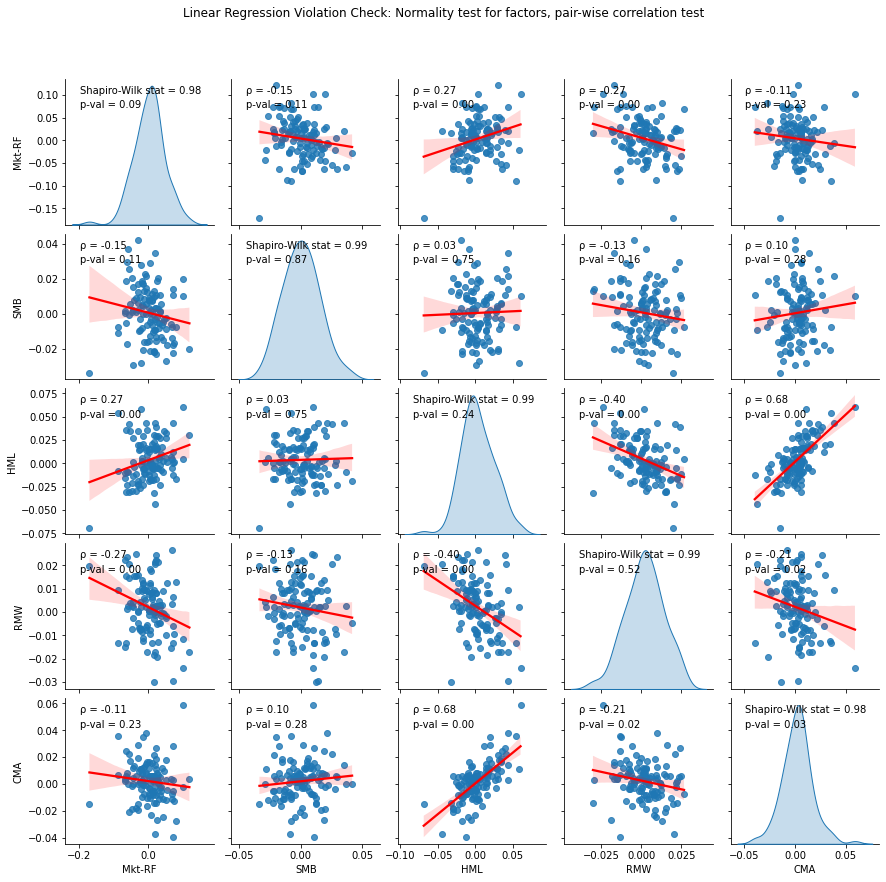

In [267]:
# Run EDA Functions on our dataset

# Generate pairplot
pp = sns.pairplot(df_ff_factors, kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

# Run the R2func for all off diagnonal cells, and normalityfunc for the diagonal ones...
pp.map_lower(R2func)
pp.map_upper(R2func)
pp.map_diag(normalityfunc)

# Title...
pp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

pp.fig.suptitle('Linear Regression Violation Check: Normality test for factors, pair-wise correlation test')

plt.show()


# Stage3: Model Design

#### Bias Alert: Complexity Bias (Training Window Size)
Part of model validation in timeseries domains is to run historic simulations, and to avoid data snooping bias, we need to use a small subset of the data we have. A relatively long history of returns is required to learn a linear regrssion model with many input variables[1], less for a classification model. If we use a ML model, which generally have more parameters, we need even more data for training. In short, we may not have high enough frequency data to train a stable model. This problem is exaccerbated when running simulations, as to avoid data snooping bias we must only use a subset of our full dataset that preceeds each simulation date.   

The more samples we have, and the more accurate the data, the more accurate our model will be. The more data we have the more features and model parameters  (ie complexity) we can employ to approximate our target function. However, there is a balanmcing act between complexity and the data available, and if our model becomes too complex for the amount of data we will likely overfit to the data, and our model will not perform well out of sample. It will be a bad predictor.

For linear factor models, the analogue is that these models assume: 
$$N >> K$$
[2] , a serious limitation requiring explicit dimensionality reduction, in a world with expanding data resources .


So how much data do we need for our chosen model? And what is the maximum number of features we should use?


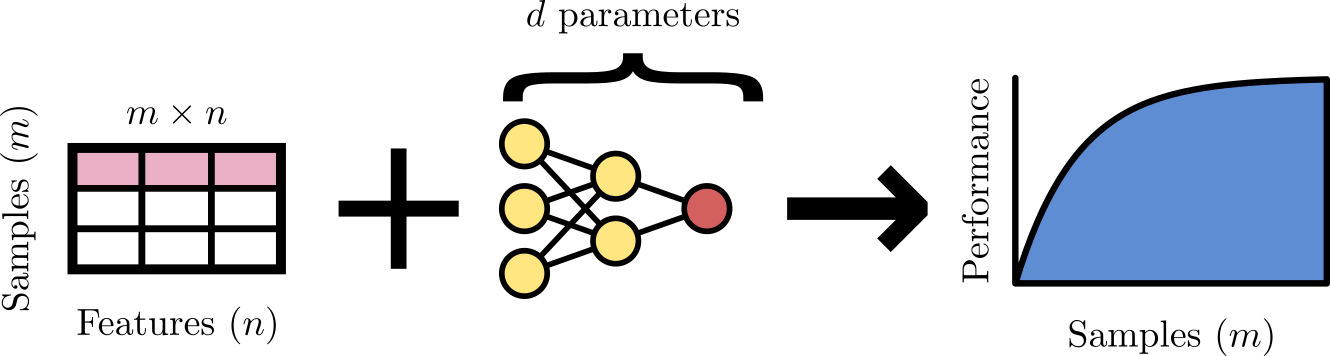


### Model complexity1: Instances vs features and classes used
A rule of thumb for the number of instances, N, needed to train a stable model with K input features, for a classification model with C categories to classify:

N ≥ 10 K · C,

instances. For a regression model:

N ≥ 50 K,

instances are suggested.


### Model complexity2: Instances vs parameters
A rule of thumb for the limit on number of parameters, ¦θ¦, our model should have, given the size of our training data [3], we suggest this: 

¦θ¦ ≤ N/10 


[1] Robert C. Merton, “On Estimating the Expected Return on the Market: An Exploratory Investigation,” Journal of Financial Economics, 8 (1980), pp. 323–361.

[2] Valliappa Lakshmanan, Sara Robinson, and Michael Munn. Machine learning design patterns. O’Reilly Media, 2020

[3] Kevin P. Murphy, Probabilistic machine learning: an introduction. MIT press, 2022

In [268]:
#***********************************************************************
#*** Complexity bias Sanity Check!***
#***********************************************************************  
def bias_complexity_check_regression(no_of_instances: int,
                          no_of_features: int = 0,
                          no_of_parameters: int = 0) -> (bool, int, int):

  '''
  Check the complexity of the mode based on rules of thumb.

  Args:
    no_of_instances: Number of rows in your dataset
    no_of_features: Number of columns
    no_of_parameters: Number of weights/coefficients/parameters in your model
      
  Returns:
      rf: sklearn model object
      
  Author:
      failed: Did the complexity check fail? Too complex...
      feature_max: maximum number of features you shluld have given the problem type and instances
      param_max: maximum number of weights/coefficients/parameters in your model given the problem type and instances
  '''

  failed = False
  cb_K = no_of_features
  cb_n = no_of_instances
  
  # 1. Feature complexity: n ≥ 50 K
  if cb_n > 50 * cb_K:
    failed = True
  
  feature_max = int(round(cb_n / 50, 0))

  # 2. Parameter complexity: ¦θ¦ ≤ n/10
  #
  # The number of model parameters (ie weights) should observe the constraint
  # wrt training instances, n, features, K:
  #
  # |theta| >= n/10  
  param_max = int(round(cb_n / 10, 0))
  
  if no_of_parameters > param_max:
    failed = True

  return (failed, feature_max, param_max)


## 3a. Traditional Quantitative approach: Linear Factors

We first examine a traditional quantitative approach noting the biases involved in the construction of a traditional stock selection model, the basis of quantitative equity investment approaches for the vast majority of quant managers.

We will use a fundamental factor model, also known as a time-series factor model, after Fama and French. 
(Please note that this is a simple factor approach. Factor investing has come a long way since these models were proposed, with flavors such as cross-sectional factor models, hidden factor models, and with applications varying from global to contextual, and more.) 

These models use linear regression to fit common factors (value (HML), small cap (SMB), etc) to stock returns, by learning coefficients (betas or factor loadings) for each factor. This has the familar form:
$$
R_{it} = α_{i} + \sum\limits_{j=1}^{K} \beta_{ij} f_{ij} + ϵ_{ij} \qquad \text{where}\; i=1,\dots, N\; j=1,\dots, K
$$
Where $R_{it}$ is the return of stock $i$ at time $t$, $\beta$ is the exposure (loading) of stock $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 

We will first learn the loadings of each stock to each of the factors in the dataset, and we will then use these loadings and the factor returns to determine the expected return of each stock to form model portfolios.     


#### Bias Alert: Researcher bias

Biases that can arise due to the researcher being influenced in both data collection, data exploration and modelling approaches proposed by previous research. Factor investing, provides a number of possible areas for researcher bias, including model design and factors to use.

#### Bias Alert: Sample Distribution Bias

If the training data and the actual data to be predicted come from different distributions, this would likely challenge to the generalization ability of a model (ie how well it performs on future input data). If a parametric model is used, such as a linear factor model, the risks of shifting distributions are likely to be greater still, even if normlization/standardization of the input data is carried out.   

We now specify our model training process, using OLS regression. We will wrap this up as a function, so as we can call it multiple times to generate return simulations over the study term.

Note that we sanity check parameters, to provide basic checks, and we analyse the residuals produced by the model to ensure residuals are normally distributed (using a SHapiro-Wilk test in this case, with the option of generating a scatter plot in the function too).
Let us run the function, using our 5 factor regression on the first security in the dataset, column=0.

Many refinements can be made to this simple model.

### 3a. i) Prep data

Our data is ready and prepared to pass into our train and predict functions.


### 3a. ii) Train, and Forecast Functions

Now we need functions to train our neural net, and to provide the final forecast of stock returns in a given time period. 
We will need these function to generate expected returns which will feed into our trade generating function, decaled earlier, and our simulation function, declared earlier.

In [269]:
# Packages to use...
import statsmodels
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Function that will run our OLS model to determine factor loadings, for a given security, 
# over a given period
# Note the two optional parameter... 
#   use_robust_cm: estimate from a robust covariance matrix
#   plot_residual_scatter: which will generate a scatter plot of our residuals (y vs y_hat)
def factormodel_train_single_security(sec_col_no: int,
                     df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int,
                     use_robust_cm: bool = False,
                     plot_residual_scatter: bool = False) -> (object, np.array, np.array):
  
  '''
  Calculate the factor loadings of a single security

  Args:
    sec_col_no: Security to select, row number in our dataframe
    df_tb3ms: Risk free rate timeseries
    df_sec_rets: stock level returns monthly, our y variable
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series, our X variables.
    date_start: training time window start period
    date_end: training time window end period
    use_robust_cm: use robust standard errors
    plot_residual_scatter: generate a graph of the residulas for the model
    
  Returns:
      ols_model: OLS, sklearn model object
      y: y variable used
      y_hat: in sample forecast of y variable.
      
  '''    

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  

  # Get X and y data...
  # NB: Security returns... deduct Rf
  y = [df_sec_rets.iloc[t, sec_col_no] - df_tb3ms.iloc[t, 0] for t in range(date_end,date_start)]
  X = df_ff_factors.iloc[date_end:date_start, :]
  
  # Instantiate and train OLS model
  # We will leave the inputs unaltered but if we normalized, it would result in 
  # an intercept of aproximately zero, making forecasting down to the stock level betas
  X = sm.add_constant(X) #<< statsmodels requires we manually add an intercept.
  ols_model = OLS(y, X)
  ols_model = ols_model.fit()

  # Optional ... Use heteroskedasticity-autocorrelation robust covariance?
  if use_robust_cm:
      ols_model = ols_model.get_robustcov_results()

  # Predict in sample
  y_hat = ols_model.predict(X)
  resid = y-y_hat
  
  # Optional ...
  if plot_residual_scatter == True:   
  
    # In sample prediction: Examine residuals for normality... 
    # NB: The null hypothesis (H0) states that the variable is normally distributed, 
    # and the alternative hypothesis (H1) states that the variable is NOT normally distributed.  
    sw_stat, sw_p = shapiro(resid)
    # Check for normality in the residuals
    if sw_p < 0.10:
      print("Residuals appear to be non-normal!") # Make an error in live code

    # square plot     
    #plt.clf()
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(y-y_hat, y_hat)
    plt.title('Residual Plot: Shapiro-Wilk p-val: ' + str(round(sw_p, 2)))
    plt.show()    

  return (ols_model, y, y_hat)

#### Vectorized Simple Factor model

The function we wrote above, "factor_model_single_security", is a simplified approach, calculating betas for one stock at a time. The matrix form of the traditional factor model is:

$$
R_{t} = \mathbf{α +β f_{t} + ϵ_{t}}
$$

We show the vectorized code to implement this version of the same function below, which can calculate many stock level betas at a time for a huge speed up. The matrix form of the factor equation above is 



Next, we forecast expected returns for each security using our factor models trained above. Again, we wrap this as a function so as we can call it multiple times in a simulation.

In [270]:
# Function that will run a vectorized OLS model, for a given security, over a given period
# Vectorized OLS regression is far faster. 
# Note the two optional parameter... 
#   use_robust_cm: estimate from a robust covariance matrix
#   plot_residual_scatter: which will generate a scatter plot of our residuals (y vs y_hat)
def factormodel_train_manysecurities(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int,
                     test_complexity: bool = True) -> (object, np.array, np.array):

  '''
  Calculate all the factor loadings of all our securities

  Args:
    df_tb3ms: Risk free rate timeseries
    df_sec_rets: stock level returns monthly, our y variable
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series, our X variables.
    date_start: training time window start period
    date_end: training time window end period
    test_complexity: test model complexity
    
  Returns:
      ols_model: OLS, sklearn model object
      y: y variable used
      y_hat: in sample forecast of y variable.
      
  '''

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  

  # Get X and y data...
  # NB: Security returns from date_end to date_start... deduct Rf
  y = np.array([df_sec_rets.iloc[t, :] - df_tb3ms.iloc[t, 0] for t in range(date_end,date_start)])
  X = np.array(df_ff_factors.iloc[date_end:date_start, :]).astype('float')

  # Prepare matrices for linalg, and OLS
  intercept = np.ones((date_start-date_end,1))
  X = np.concatenate((intercept, X), axis=1)

  # Flag nan containing security returns
  cols_non_nan = ~np.isnan(y).any(axis=0)
  y_train = y[:,cols_non_nan]

  # Sanity Check: Biases ************************
  if test_complexity == True:
    failed, _, _ = bias_complexity_check_regression(no_of_instances=X.shape[0], # Try to use  36month window to train the MLP
                                        no_of_features=X.shape[1], # Do not count intercept
                                        no_of_parameters=X.shape[1]) 
    if failed == True:
      print("************ Complexity bias warning ***************")  
  # Sanity Check: Biases ************************

  # Train model
  ols_betas, resid, rank, sigma = np.linalg.lstsq(a=X, b=y_train, rcond=None)  

  # Predict in sample
  y_hat = np.dot(X, ols_betas)
  resid = y_train - y_hat

  # We removed nan rows... Rebuild to a full vector
  ols_betas_final = pd.DataFrame(np.zeros((ols_betas.shape[0], y.shape[1])))
  ols_betas_final.loc[:, cols_non_nan] = ols_betas

  ols_betas_final.columns = df_sec_rets.columns
  ols_betas_final.index = ['const'] + df_ff_factors.columns.to_list()
  return (ols_betas_final, y, y_hat)


In [271]:
# Forecast the expected return of a single stock
def factormodel_forecast_er(df_stock_factor_loadings: pd.DataFrame,
                            df_ff_factors: pd.DataFrame,
                            r_f: float, 
                            date_start: int,
                            date_end: int) -> np.array:

  '''
  Forecast expected return using factor based approach

  Args:
    df_stock_factor_loadings: Factor loadings for all out stocks, and all factors
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series, our X variables.
    r_f: Risk free rate to use
    date_start: training time window start period
    date_end: training time window end period
    
  Returns:
      e_r: expected return forecast
      
  '''

  #df_stock_factor_loadings=pd.DataFrame(ols_coefs) 
  #df_ff_factors=df_ff_factors
  #r_f=df_tb3ms.iloc[t, 0]
  #date_start = 80+12
  #date_end = 12

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.shape[1] != df_stock_factor_loadings.shape[0]-1: #Include the intercept dimension
    raise TypeError("Must pass same number of factors for security as the df_ff_factors")  

  # Factor returns to assume
  factor_excess_returns = df_ff_factors.iloc[date_end:date_start, :].sort_index()
  factor_excess_returns = np.array(1+factor_excess_returns).prod(axis=0)
  factor_excess_returns = factor_excess_returns ** (12/(date_start-date_end))-1

  # Stock Forecast E(R)_i,t+h
  e_r = np.dot(factor_excess_returns.T, df_stock_factor_loadings.iloc[1:, :])

  #Only add constant and r_f to (non zero returns) populated securities
  non_zero_secs = e_r != 0
  e_r[non_zero_secs] = e_r[non_zero_secs] + r_f + df_stock_factor_loadings.loc['const', non_zero_secs]

  return e_r


In [272]:
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def factormodel_forecast_all_er(df_benchmark_trades: pd.DataFrame,
                                df_tb3ms: pd.DataFrame,
                                df_sec_rets: pd.DataFrame,
                                df_ff_factors: pd.DataFrame,
                                window_size: int = 36,
                                factor_return_history: int = 36,
                                winsorize_er: float = 0) -> pd.DataFrame:

  '''
  Forecast ALL expected returns, for all securities, all time periods, using factor based approach

  Args:
    df_benchmark_trades: only calculate er for benchmark positions, can leave as None...
    df_tb3ms: Risk free rate timeseries
    df_sec_rets: stock level returns monthly, our y variable
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series, our X variables.
    window_size: number of months to use, to calculate stock level factor loadings
    factor_return_history: number of months to calculate mean factor returns, which is our assumption for future factor returns 
    winsorize_er: Some researchers remove extreme forecats, specify the higher/lowest winsorize_er percentile of rstock forecasts to remove
    
  Returns:
      df_stock_er: expected return forecasts
      
  '''
  
  # E(R) for each stock, in each time period
  df_stock_er = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_stock_er.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_stock_er.columns = df_sec_rets.columns                          
  #
  df_stock_SW_pval = df_stock_er.copy(deep=True)

  # start period?
  if df_benchmark_trades is None:
    start_period = df_ff_factors.shape[0]
  else:
    start_period = min(df_benchmark_trades.shape[0], df_ff_factors.shape[0])  

  # Progress
  pbar = tqdm()
  pbar.reset(total=df_ff_factors.shape[0]-window_size-1)  # initialise with new `total`
    
  #Step through time... earliest to latest.
  for t in range(start_period-window_size-1, -1, -1):
    
    # Progress
    pbar.update()
    
    # Run our function, returning only the result object
    ols_coefs, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets, 
                                              df_ff_factors=df_ff_factors, 
                                              date_start=t+window_size, #<< Note we pass in the start date here
                                              date_end=t,
                                              test_complexity = False)  #<< Note we pass in the end date here

    # Generate E(R) from our stock level factor model...      
    # Factor return assumption      
    e_r = factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_coefs), 
                                    df_ff_factors=df_ff_factors,
                                    r_f=df_tb3ms.iloc[t, 0],
                                    date_start=t+factor_return_history,
                                    date_end=t) 

    df_stock_er.iloc[t,:] = e_r

  # Set zeros to nan
  def zero_to_nan(x):
    if round(x, 4) == 0:
      x = np.nan
    return x

  df_stock_er = df_stock_er.applymap(zero_to_nan) 

  # winzorize?
  if winsorize_er > 0:
    winsorize_er = 0.05
    # Get upper and lower limit to remove by col
    upper_kill = df_stock_er.quantile(q=1-winsorize_er, axis=1)
    lower_kill = df_stock_er.quantile(q=winsorize_er, axis=1)

    def winsorize(row):
      zero_out = (row >= upper_kill[row.name]) | (row <= lower_kill[row.name])
      row.loc[zero_out] = np.nan
      return row

    #Kill df_stock_er
    df_stock_er.apply(winsorize, axis=1)   

  # Progress
  pbar.refresh()  

  return df_stock_er

# Run the function with our data
df_all_er = factormodel_forecast_all_er(df_benchmark_trades=None,
                                        df_tb3ms=df_tb3ms, 
                                        df_sec_rets=df_sec_rets,
                                        df_ff_factors=df_ff_factors,
                                        window_size=36)


# Test an example
test_this_stock = df_all_er.columns[0]
df_all_er.columns.get_loc(test_this_stock)

0it [00:00, ?it/s]

0

In [273]:
df_sec_rets

TICKER,ZEUS-US,WTBA-US,WRLD-US,VRTS-US,VMO-US,VCV-US,SCHL-US,SAR-US,RVT-US,RGR-US,...,CHN-US,CENX-US,BUI-US,BPT-US,BNY-US,BME-US,APOG-US,AMOT-US,AMN-US,AAN-US
DATE,,,,,,,,,,,,,,,,,,,,,
202207,0.154563,0.068611,-0.013052,0.215350,0.055967,0.027597,0.308590,-0.016688,0.132427,0.038963,...,-0.123473,0.070556,0.054973,-0.058160,0.044241,0.038584,0.067074,0.179510,0.024884,-0.105155
202206,-0.246415,-0.043615,-0.241980,-0.112322,-0.035206,-0.031999,-0.041567,-0.078458,-0.069689,-0.062454,...,0.161314,-0.375424,-0.023252,0.029160,-0.068359,-0.026415,-0.057212,-0.069275,0.132198,-0.251060
202205,-0.002039,0.028350,-0.215357,0.087492,0.036562,0.039670,0.018453,0.038702,-0.003245,0.006519,...,0.012859,-0.300533,-0.040708,0.528824,0.068916,0.014529,-0.049514,0.009310,-0.008696,-0.047248
202204,-0.107384,-0.081220,-0.016316,-0.255785,-0.084864,-0.040012,-0.081466,-0.061629,-0.092996,-0.021115,...,-0.104336,-0.358799,-0.065780,-0.069235,-0.080139,-0.042852,-0.072903,-0.184316,-0.063069,0.022410
202203,0.436683,-0.058478,-0.023566,-0.002618,-0.030902,-0.049852,-0.042776,0.011614,-0.005423,-0.026799,...,-0.084935,0.113887,0.067291,0.187153,-0.054363,0.059348,0.053029,-0.142307,-0.017053,-0.038564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201303,0.156265,0.002710,0.091106,0.108744,-0.018053,-0.042989,-0.114618,-0.032897,0.030015,-0.064399,...,-0.020969,-0.045062,0.019091,0.041412,-0.064600,0.027654,0.122528,-0.014286,0.122695,0.050934
201302,-0.015221,0.009116,0.014829,0.127508,-0.027509,0.012045,0.014835,-0.043820,0.021379,0.075635,...,-0.044949,-0.058140,0.016326,0.032985,-0.008695,0.025848,0.058740,0.042285,0.160494,-0.079595
201301,-0.051039,0.026902,0.040102,0.232098,0.032816,0.007656,0.007579,0.155844,0.080477,0.118282,...,0.049510,-0.018444,0.076579,0.166949,0.023306,0.063169,0.020025,0.021212,0.051948,0.048444


### 3a. iii) Test run of our model

Let us call our functions to train a factor model for the first security in the dataset(factormodel_train_single_security) using the full term of the data available, and then calculate this security's expected returns (factormodel_forecast_ER). We will also opt to generate a residual plot (by setting factormodel_train_single_security parameters to plot_residual_scatter=True).
Our function will also print the summary stats for the regression.
Finally we will set a sanity check for normality of the redisuals. If the Shapiro-Wilk test produces a p-val of >10\% we can accept the null hypothesis, implying that the distribution of residuals is normal. 

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


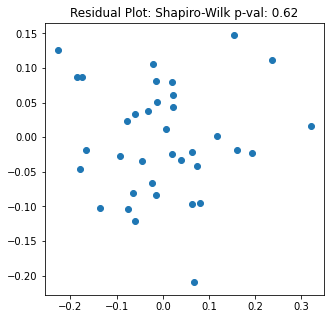

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2.595
Date:                Wed, 04 Jan 2023   Prob (F-statistic):             0.0458
Time:                        16:37:18   Log-Likelihood:                 25.160
No. Observations:                  36   AIC:                            -38.32
Df Residuals:                      30   BIC:                            -28.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0136      0.023     -0.599      0.5

In [274]:

# Get an example equity
i = df_sec_rets.columns.get_loc(test_this_stock) #AAWW-US') #'ABG-US')
t = 19

# Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
ols_model, y, y_hat = factormodel_train_single_security(sec_col_no=i, 
                                             df_tb3ms=df_tb3ms, 
                                             df_sec_rets=df_sec_rets, 
                                             df_ff_factors=df_ff_factors, 
                                             date_start=t+36, 
                                             date_end=t, 
                                             plot_residual_scatter=True)
# Examine the fit, coefficients and OLS analytics.
print(ols_model.summary())

# Forecast E(R) for this security.
df_stock_er = factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_model.params), 
                                df_ff_factors=df_ff_factors, 
                                r_f=df_tb3ms.iloc[0,0],
                                date_start=t+36, 
                                date_end=t,)

print("Expected Return Forecast for this stock")
print(df_stock_er)


### 3a) iv) Factor Model Applied Over Time
We now use our functions to conduct a historic simulation, stepping forward over time points in our dataset, and using a 36month sliding window to train the model for each security, at each timestep. We start in the earlies time period and end at the most recent period, generating a expected returns for each stock as we go.
At the end of this process we will be able to say which stocks we favor, and which we do not in each time period, based on the expected return our models will have predicted.


#### Simple Simulation Functions
Having run the Factor model we have forecast expected return for each security in each time step in the test period. We now need to convert these predictions into portfolio positions, to run a historic simulation.This will allow us to test how effective our stock selection is based on the forecasts of expected return.

In each period we select the top quantile (defaulting to 25th percentile) of our stock forecasts, and generate a DataFrame of equal weighted stocks that reside in this quantile.
Next we assume a certain rebalance frequency, and simualte the past returns of this portfolio. 

#### Bias Alert: Backtesting Bias

Back-testing bias is generally a form of forward-look (or data snooping) bias, where an analyst will check the performance of an approach over the past, and will tend to reject all approaches that perform poorly. In a sense the analyst becomes endogenous to the model, using look-ahead to bias model selection to only those that have worked.

This can be addressed by testing only a small number of approaches in this manner (ie avoiding violation of independence assumptions), with strong investment rationales (ie causality); and/or by observing the posterior distribution, rather than the point outcomes for the approaches tested (please see earlier materials on target-shuffling).

#### Bias Alert: Time-Interval/Forward Look Bias
When researcher selects a specific timeframe for training vs. validating vs. testing to support hypotheses and/or uses “restated” data not available during the time under study. 

In [275]:
# Establish trades for 6monthly rebalances: Return a full DF of trade weights (per column/security)
# For every time slice, set the highest quantile as equal weighted trades
# Quantiles have nan entries and zero entries removed
def trades_topquantile_generate(df_all_er: pd.DataFrame,
                            rebalance_freq: int,
                            min_quantile_to_buy: float = 0) -> pd.DataFrame:

  '''
  Generate simple trades, >=min_quantile_to_buy of df_all_er. Equal weight the stocks selected

  Args:
    df_all_er: ALl stock and timeperiod expected returns
    rebalance_freq: how often to calculate quantile trades?
    min_quantile_to_buy: >=quantile to model equal weighted trades

  Returns:
      df_stock_er: expected return forecasts
      
  '''
    
  # Sanity
  if df_all_er.index[1] < df_all_er.index[2]:
    raise TypeError("Sort order of dates is wrong. Latest date should be at the top.")
  if (rebalance_freq < 0 == True) | (rebalance_freq > 60 == True):
    raise TypeError("rebalance_freq < 0 | rebalance_freq > 60.")
  if (min_quantile_to_buy < 0 == True) | (min_quantile_to_buy > 1 == True):
    raise TypeError("min_quantile_to_buy < 0 | min_quantile_to_buy > 1")

  # Initialise df_trades
  df_trades = pd.DataFrame(np.zeros((df_all_er.shape[0],df_all_er.shape[1])), columns=df_all_er.columns, index=df_all_er.index)  
  insert_zero_row = False # Error? or zero values? We insert a zero row...
  date_start_non_zero = -1 # What is the first non-zero row 

  # Progress
  pbar = tqdm()
  pbar.reset(total=round((df_all_er.shape[0]-rebalance_freq)/rebalance_freq,0))  # initialise with new `total`

  # Loop through time... start to end.
  # Progress bar
  for t in range(df_all_er.shape[0]-1,0,-rebalance_freq): 
    # Progress
    pbar.update()

    # Get this period's stocks (cols), get valid stocks only
    df_opset_curr = pd.DataFrame(df_all_er.iloc[t, :]).T
    valid_secs = (df_opset_curr.iloc[0, :].isna() | df_opset_curr.iloc[0, :] != 0).to_numpy()

    # Get our securities above the min_quantile_to_buy
    qu = df_opset_curr[df_opset_curr.columns[valid_secs]].quantile(q=min_quantile_to_buy, axis=1).iloc[0]   
    # Capture all valid securities if min_quantile_to_buy==0 (ie universe securities)
    if min_quantile_to_buy == 0:
      qu = qu - 1
    # How many securities is that?
    no = df_opset_curr[df_opset_curr[df_opset_curr.columns[valid_secs]] > qu].count(axis=1).iloc[0]

    #Create trades row    
    df_trades_curr = pd.DataFrame(df_all_er.iloc[t, :]).T
    df_trades_curr.astype(float)
    df_trades_curr.iloc[:,:] = float(0)
    if no != 0:
      # Add equal weighted trades...
      trade_secs = ((df_opset_curr.iloc[0, :] > qu) & (df_opset_curr.iloc[0, :] != 0))
      df_trades_curr[df_trades_curr.columns[trade_secs]] =  1/no   

      #Record the first non-zero row
      if date_start_non_zero == -1: 
          date_start_non_zero = t

      insert_zero_row = False
    else:
      insert_zero_row = True

    # Insert zero row...
    if insert_zero_row == True: 
      df_trades_curr = pd.DataFrame(df_all_er.iloc[t, :]).T
      df_trades_curr.iloc[:,:] = float(0.00000)

    # Overwrite date/time row in df_trades
    df_trades = df_trades.drop(axis=0, index=df_trades_curr.index)
    df_trades = df_trades.append(df_trades_curr)

  # Correct the sort order...
  df_trades = df_trades.sort_index(ascending=False)

  #Sanity... Trades in each period totals a max of 100%? if non-zero.
  if ((df_trades.sum(axis=1).max() > 1.001 == True) | (df_trades.sum(axis=1).max() < 99.999 == True)):
    raise TypeError("Sanity checks on returns failed")

  # Progress
  print('Top quantile generated')
    
  return df_trades

df_trades = trades_topquantile_generate(df_all_er=df_all_er, 
                                        rebalance_freq=6, 
                                        min_quantile_to_buy=0)

0it [00:00, ?it/s]

Top quantile generated


We can review the trades created. Trades should be an equal size in each period, and should be created in those securities where the value is greater than the quantile specified (top 25% by default) 

Take the trades we have just generated and run a historic simulation.

A historic simulation. A simple simulation function 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.106389
Standard deviation (SD) (annualized),0.237116
Sharpe Ratio (TR/SD),0.448677
Hit rate (monthly),0.608108


,Descriptive Stats
Mean (TR),0.010985
Median (TR),0.022500
Variance (TR),0.004685
Skewness (TR),-0.961084
Kurtosis (TR),1.629174


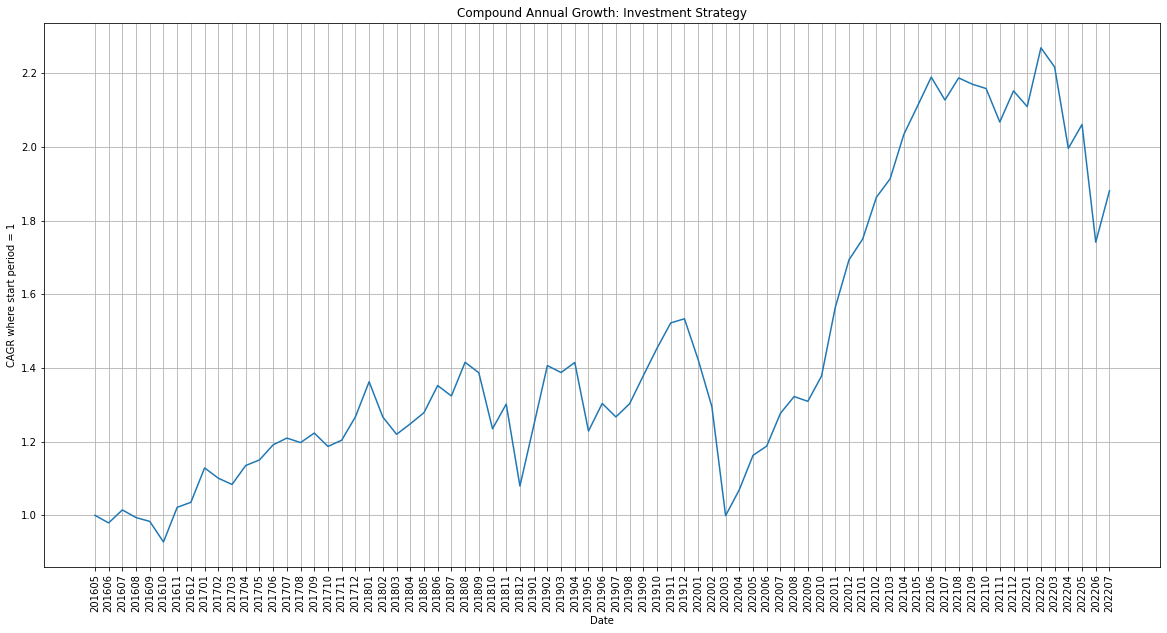

In [300]:
import matplotlib
import matplotlib.pyplot as plt
import math

from scipy import stats 

# Simulation routine
def run_sim(df_trades: pd.DataFrame,
            df_sec_rets: pd.DataFrame, 
            rebalance_freq: int = 6,
            transaction_costs: float = 0.001,
            print_chart: bool = True,
            date_start_of_sim: int = -1,
            warnings_off: bool = False) -> (pd.DataFrame, object):

  '''
  Run a historic simulation of full rebalance portfolios

  Args:
    df_trades: DataFrame with trades to incept at the frequency rebalance_freq
    df_sec_rets: stock level returns monthly, our y variable
    rebalance_freq: how often to calculate quantile trades?
    transaction_costs: costs to apply to changes in position
    print_chart: show analytic diagnostic information
    date_start_of_sim: start date from which to start. Continue to the end of the data.

  Returns:
      df_sec_cagr: expected return forecasts
      plt: return the plot object so we can add other series to it - only works if we are printing a chart
      
    '''

  # Sanity
  # Period1 must have a 100% allocation...
  if ((df_trades.sum(axis=1).max() > 1.001 == True) | (df_trades.sum(axis=1).max() < 99.999 == True)):
    raise TypeError("Trades pass in do not all sum to 100%")
  if df_trades.index[0] < df_trades.index[-1]:
    raise TypeError("df_trades needs to have the latest date at the top")
  if date_start_of_sim > df_trades.shape[0]:
    raise TypeError("date_start_of_sim > df_trades.shape[0]-2")

  if date_start_of_sim == -1:
    date_start_of_sim = df_trades.shape[0]-2

  # Ini CAGR of each security as the initial trade
  df_sec_cagr = pd.DataFrame(np.zeros((date_start_of_sim+2, df_trades.shape[1])), columns=df_trades.columns, index=df_trades.index[0:date_start_of_sim+2])
  df_sec_cagr.astype(float)
  df_sec_cagr.columns = df_trades.columns
  df_sec_cagr = df_sec_cagr.astype(float)
  df_trades = df_trades.astype(float)
  cagr_total = -1
  period_no = -1

  # Progress
  if warnings_off == False:
    pbar = tqdm()
    pbar.reset(total=date_start_of_sim)  # initialise with new `tota

  # Step through time: rebalance_freq
  for t in range(date_start_of_sim, -1, -1):
    if warnings_off == False:
      # Progress
      pbar.update()

    # Trades in period?
    if (df_trades.iloc[t,:].sum() != 0):
      # Start positions
      #===============================================
      if cagr_total == -1:
        df_sec_cagr.iloc[t,:] = df_trades.iloc[t,:]
        cagr_total = df_sec_cagr.iloc[t,:].sum(skipna=True)
        period_no = 0

        #Sanity
        if (round(cagr_total, 2) != 1):
          raise TypeError("Initial trades do not equal 100% Row: " + str(i) + ', total:' + str(round(cagr_total,2)))       

      else:
        # Establish any buy trades in the period...
        #================================================
        trade_buy_flag = ((df_trades.iloc[t,:] != np.nan) & (df_trades.iloc[t,:] > 0)).to_list()
        trade_buy_cols = df_trades[df_trades.columns[trade_buy_flag]]    
        tot_buy_trades = df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:].sum(skipna=True) 
        
        # Sanity: All trades are assumed to be rebalances of 100% of the portfolio
        if round(tot_buy_trades,2) != 1:
          raise TypeError('Trades must equal 100% not:')  
        if df_trades.columns[trade_buy_flag].__len__() == 0:
          raise TypeError('No valid trades')  

        # Positions roll forwards...
        #================================================
        df_sec_cagr.iloc[t,:] = df_sec_cagr.iloc[t+1,:] * (1+df_sec_rets.iloc[t,:])
        cagr_total = df_sec_cagr.iloc[t,:].sum()

        # Execute Sell/Buys instantaneously at the close.
        # (We overwrite the CAGR of the buy trades with the new trade* cagr_total,
        # and we zero out the sell trades, having already added their contribution to the cagr_total)
        #================================================      
        # Remove all positions
        df_sec_cagr.iloc[t, :] = 0
        #df_sec_cagr[df_sec_cagr.columns[trade_buy_flag]].iloc[t,:] = df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:].copy() * cagr_total
        for j in range(df_sec_cagr.shape[1]):
          if trade_buy_flag[j]:
            df_sec_cagr.iloc[t,j] =  df_trades.iloc[t,j] * cagr_total
        
        #Sanity
        if len(df_trades.columns[trade_buy_flag]) == 0:
          raise TypeError('df_trades.columns[trade_buy_flag].__len__() == 0')       
        if len(df_sec_cagr.columns[trade_buy_flag]) == 0:
          raise TypeError('f_sec_cagr.columns[trade_buy_flag].__len__() == 0')       

        #Transaction costs
        #trans_costs_current = abs(df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:] - df_sec_cagr[df_sec_cagr.columns[trade_buy_flag]].iloc[t,:]/cagr_total)
        #trans_costs_current_applied = df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:] * -abs(trans_costs_current)
        #trans_costs_current_applied = trans_costs_current_applied.copy(deep=True)
        #df_sec_cagr[df_sec_cagr.columns[trade_buy_flag]].iloc[t,:] += trans_costs_current_applied
        trans_costs_current = abs(df_trades.iloc[t,:] - df_sec_cagr.iloc[t,:]/cagr_total)
        for j in range(df_sec_cagr.shape[1]):
          if trade_buy_flag[j]:
            df_sec_cagr.iloc[t,j] += df_trades.iloc[t,j] * -abs(trans_costs_current.iloc[j])

        period_no += 1
    else:
      # No trades... Positions roll forwards...
      #================================================      
      #Sanity
      if df_sec_rets.iloc[t,:].abs().sum(skipna=True) == 0:
        raise TypeError("Returns are zero in period: " + str(i))       
      #df_sec_cagr.iloc[t,:] = df_sec_cagr.iloc[t+1,:] * (1+df_sec_rets.iloc[t,:])
      for j in range(df_sec_cagr.shape[1]):
          df_sec_cagr.iloc[t,j] =  df_sec_cagr.iloc[t+1,j] * (1+df_sec_rets.iloc[t,j])
      
      period_no += 1

  # Sort into date order
  df_sec_cagr = df_sec_cagr.sort_index(ascending=False)

  #Analytics: 
  if print_chart == True:    
    p = sim_chart(df_sec_cagr=df_sec_cagr)
    p.show()
  else:
    p = None

  return (df_sec_cagr, p)

def sim_chart(df_sec_cagr: pd.DataFrame):
  '''
  Print return based analytics and chart CAGR

  Args:
    df_sec_cagr: DataFrame continaing compound annual growth series of the strategy to be charted
    period_no: Number of periods in the above series to chart/analyze.

  Returns:
      None      
    '''
  
  # ini
  df_final = df_sec_cagr.sum(axis=1, skipna=True)
  period_count = [x for x in range(df_final.shape[0]-1, 0, -1) if df_final.iloc[x] != 0].__len__()+1
  df_final = df_final.iloc[0:period_count].astype(float)
  df_final_mom_tr = pd.DataFrame(df_final.iloc[:-1].values/df_final.iloc[1:].values -1)
  
  # Analytics
  sim_ana = pd.DataFrame(np.zeros((4,1)))
  idx = ['Total Return (TR)(annualized)'] 
  sim_ana.iloc[0,0] = df_final.iloc[0] ** (12/period_count) -1
  idx.append('Standard deviation (SD) (annualized)')
  sim_ana.iloc[1,0] = df_final_mom_tr.std() * math.sqrt(12)
  idx.append('Sharpe Ratio (TR/SD)')
  sim_ana.iloc[2,0] = float(sim_ana.iloc[0,0]) / float(sim_ana.iloc[1,0])
  idx.append('Hit rate (monthly)')
  sim_ana.iloc[3,0] = df_final_mom_tr[df_final_mom_tr>=0].iloc[:,0].count() / df_final_mom_tr[df_final_mom_tr!=0].iloc[:,0].count()
  sim_ana.columns = ['Analytics']
  sim_ana.index = idx
  display(sim_ana)  

  # Descriptive stats
  sim_ana2 = pd.DataFrame(np.zeros((5,1)))
  idx = ['Mean (TR)'] 
  sim_ana2.iloc[0,0] = df_final_mom_tr.mean()
  idx.append('Median (TR)')
  sim_ana2.iloc[1,0] =  df_final_mom_tr.median()
  idx.append('Variance (TR)')
  sim_ana2.iloc[2,0] = df_final_mom_tr.var()
  idx.append('Skewness (TR)')
  sim_ana2.iloc[3,0] = stats.skew(df_final_mom_tr)
  idx.append('Kurtosis (TR)')
  sim_ana2.iloc[4,0] = stats.kurtosis(df_final_mom_tr)
  sim_ana2.columns = ['Descriptive Stats']
  sim_ana2.index = idx
  display(sim_ana2)  

  #CAGR chart  
  plt.figure(figsize=(20,10))
  plt.plot([t for t in range(0, period_count)], df_final.iloc[0:period_count])    
  plt.xticks([t for t in range(0, period_count)],df_final.index[0:period_count])
  ax = plt.gca()
  ax.invert_xaxis()
  plt.xticks(rotation = 90)
  plt.title('Compound Annual Growth: Investment Strategy')
  plt.xlabel('Date')
  plt.ylabel('CAGR where start period = 1')    
  plt.grid()     

  return plt

def sim_chart_add_series(p: object,
                        df_cagr: pd.DataFrame,
                        series_name: str):
  '''
  Add series to existing sim_chart(...,print_chart=True) CAGR chart

  Args:
    p: plt object created from sim_chart
    df_cagr: DataFrame continaing compound annual growth series of the strategy to be charted
    title: ... name of this return series

  Returns:
      None
      
  '''

  # Sanity
  if p is None:
    raise TypeError('p object is none. Need to pass the 2nd return object from run_sim to this function. Remember to set print_chart=True in the call to run_sim')

  # Get the dimensions of the x-axis of p
  ax = p.gca()
  line = ax.lines[0]
  first_value = [x for x in range(line.get_ydata().__len__()-1, 0, -1) if line.get_ydata(0)[x] != 0].__len__()+1

  # Add series
  p.plot([t for t in range(0, first_value)], df_cagr.iloc[0:first_value], label=series_name)

  return

# get the first period trades are present in
def start_period_trades(df_trades: pd.DataFrame) -> int:

  #Step through time... earliest to latest-forecast_ahead.
  t_first_trade = -1
  for t in range(df_trades.shape[0]-1, 0, -1):
    if round(df_trades.iloc[t,:].sum(), 1) == 1:
      t_first_trade = t
      break

  return t_first_trade

#====================================
# Run the Linear factor model
#====================================

# FF model
df_lin_all_er = factormodel_forecast_all_er(df_benchmark_trades=None,
                                        df_tb3ms=df_tb3ms, 
                                        df_sec_rets=df_sec_rets,
                                        df_ff_factors=df_ff_factors,
                                        window_size=36,
                                        winsorize_er=0)

# Run the function to establish simple positio sizes based
df_lin_trades = trades_topquantile_generate(df_all_er=df_lin_all_er, 
                                        rebalance_freq=6, 
                                        min_quantile_to_buy=0.75)

# Run the simulation function
df_sec_cagr, p = run_sim(df_trades=df_lin_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         date_start_of_sim=79)  


Now we construct a simple benchmark from our universe...

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.146367
Standard deviation (SD) (annualized),0.212841
Sharpe Ratio (TR/SD),0.687684
Hit rate (monthly),0.662162


,Descriptive Stats
Mean (TR),0.013483
Median (TR),0.019421
Variance (TR),0.003775
Skewness (TR),-0.271161
Kurtosis (TR),3.544590


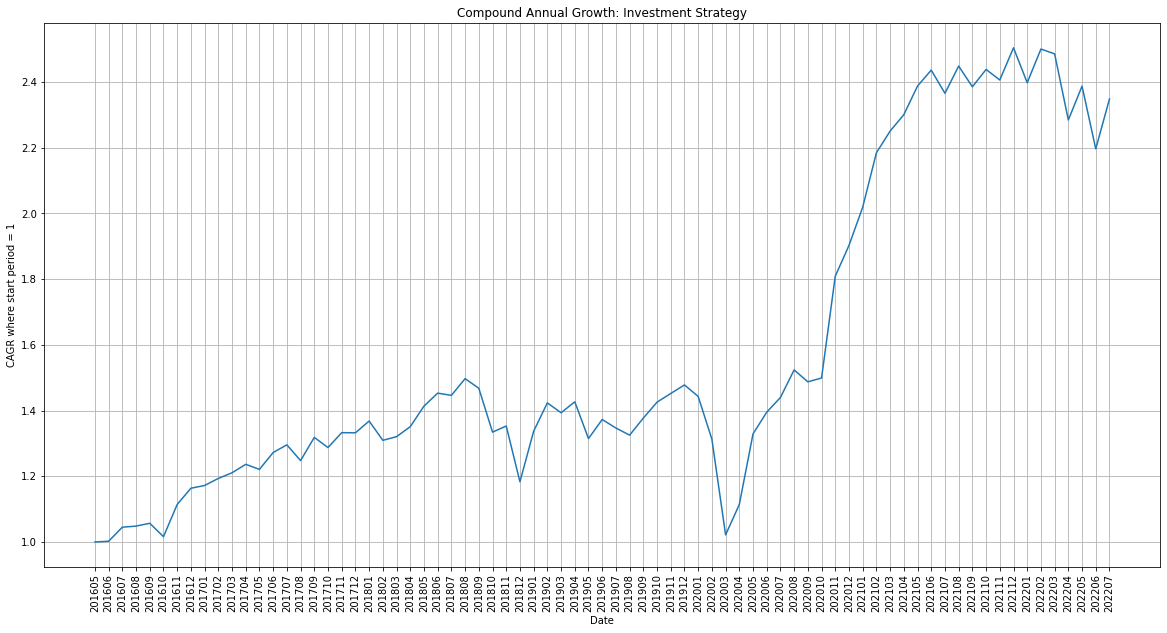

In [277]:
#====================================
# Create universe benchmark
#====================================
# Run the function to establish simple positions
df_benchmark_trades = trades_topquantile_generate(df_all_er=df_lin_all_er, rebalance_freq=6, min_quantile_to_buy=0)

df_sec_rets_copy = df_sec_rets.copy(deep=True)
df_sec_rets_copy[df_sec_rets_copy>5] = 5

# Create an equal weighted benchmark of all valid securities
# Run the simulation function
df_benchmark_sec_cagr, p = run_sim(df_trades=df_benchmark_trades, 
                                    rebalance_freq=6, 
                                    df_sec_rets=df_sec_rets_copy, 
                                    date_start_of_sim=79)  

0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.106389
Standard deviation (SD) (annualized),0.237116
Sharpe Ratio (TR/SD),0.448677
Hit rate (monthly),0.608108


,Descriptive Stats
Mean (TR),0.010985
Median (TR),0.022500
Variance (TR),0.004685
Skewness (TR),-0.961084
Kurtosis (TR),1.629174


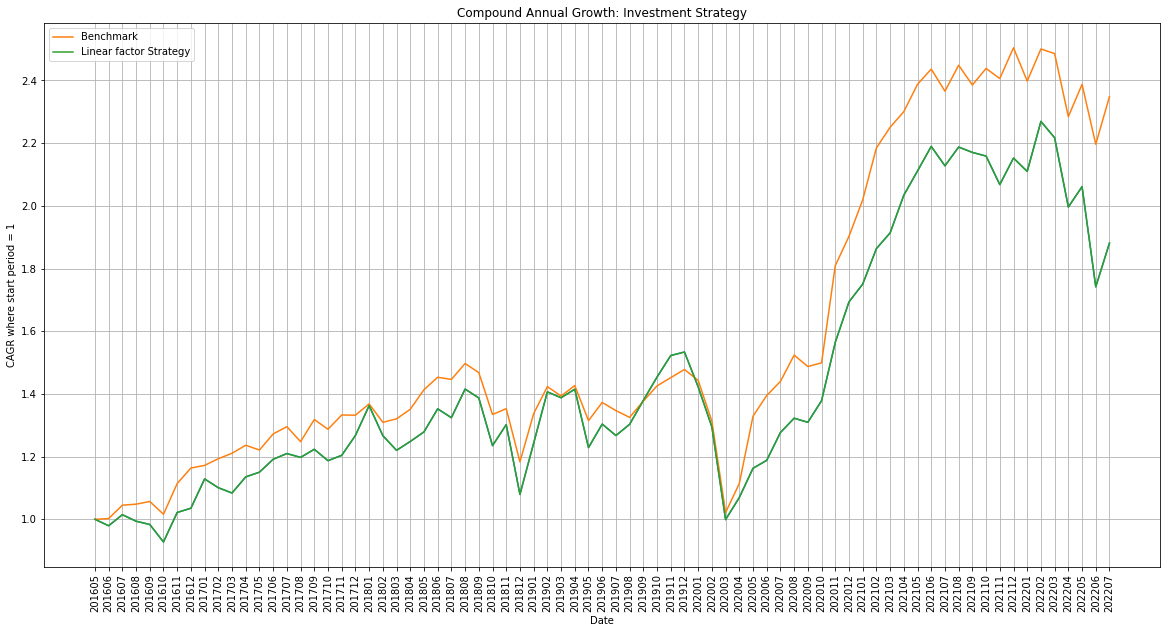

In [278]:
# Plot the linear-factor model CAGR vs the benchmark
df_lin_sec_cagr, p = run_sim(df_trades=df_lin_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=79)  

# Chart
p = sim_chart(df_sec_cagr)
sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
p.legend()
p.show()

Benchmarking returns can give a msleading impression of how significant performance or risk adjusted returns are. As we saw in previous modules, we can construct an empirical distribution of returns using "target shuffling lite". This allows us to look at many of the combintions of securities we could have held over the study term (using the same assumptions as our simulation: same number of stocks as the portfolio and the same rebalance periofs and so on). A comparison of our simualtion with this distribution camn be enlightening.

In [280]:
from numpy import random
from scipy import stats

import matplotlib.ticker as mtick

import multiprocessing

# Target shuffling "lite": get empirical distribution of opportunity-set
def _target_shuffling_get_dist(df_opportunity_set_trades: pd.DataFrame,
                            min_quantile_to_buy: float, 
                            df_sec_rets: pd.DataFrame, 
                            rebalance_freq: int = 6,
                            iterations: int = 100,
                            q: multiprocessing.Queue = None) -> pd.DataFrame:

  '''
  Return the empirical distribution of possible return outcomes for the opportunity-set selected  
  This can be extended to return outcomes for the learner selected
  Randomly shuffle the "buy" names, same opportunity set as the model used
  which removes securities excluded fom the models owing to NaNs in training windows etc etc
  
  Args:
    df_opportunity_set_trades: DataFrame with the full opportunityset of trades from the model being tested (ie min_quantile_to_buy set to 0)
    min_quantile_to_buy: what is your model selecting? to 20th percentile? Thats what we will simulate on here.
    df_sec_rets: stock level returns monthly, our y variable
    rebalance_freq: how often to calculate quantile trades?
    iterations: number of times we create and sim random portfolios. 
    q: for multiprocessing of this function. Leave as None to run normally.

  Returns:
      df_sec_cagr: end cagr for each of the (iterations) sims
  '''

  # Sanity
  if min_quantile_to_buy == 0:
    raise TypeError('min_quantile_to_buy == 0')
  
  # Find the first trades
  for t in range(df_opportunity_set_trades.shape[0]-1, -1, -1):
    if df_opportunity_set_trades.iloc[t,:].sum() > 0:
      t_start = t
      break
  
  # Ini: 
  dt_sim_tr = pd.DataFrame(np.zeros((iterations, 4)))

  dt_rnd_trades = pd.DataFrame(np.zeros((df_opportunity_set_trades.shape[0], df_opportunity_set_trades.shape[1])))
  dt_rnd_trades.columns = df_opportunity_set_trades.columns
  dt_rnd_trades.index = df_opportunity_set_trades.index
 
  for i in range(iterations):

    #randomly allocate trades
    for t in range(t_start, -1, -rebalance_freq):
      curr_date = df_opportunity_set_trades.index[t]
      # opportunity set secs      
      op_set_cols_mask = df_opportunity_set_trades.iloc[t,:] > 0
      rnd_buys = random.rand(op_set_cols_mask.sum())
      #Set random trades
      rnd_buys[rnd_buys < np.quantile(rnd_buys, min_quantile_to_buy)] = 0
      rnd_buys[rnd_buys != 0] = 1 / np.count_nonzero(rnd_buys) # Equal weight stocks...
      
      #Set random trades
      dt_rnd_trades.loc[curr_date, op_set_cols_mask] = rnd_buys

      # Sanity
      if round(dt_rnd_trades.loc[curr_date, :].sum(), 1) != 1:
        raise TypeError('dt_rnd_trades.loc[curr_date, :] != 1')
    
    # Run the simulation function
    df_sec_cagr, p = run_sim(df_trades=dt_rnd_trades, 
                          rebalance_freq=6, 
                          df_sec_rets=df_sec_rets,
                          print_chart=False,
                          warnings_off=True)  

    # Calc TR, sd, Sharpe   
    df_cagr = df_sec_cagr.sum(axis=1)
    
    period_count = [x for x in range(df_cagr.shape[0]-1, 0, -1) if df_cagr.iloc[x] != 0].__len__()
    df_final_mom_tr = pd.DataFrame(df_cagr.iloc[:period_count-1].values/df_cagr.iloc[1:period_count].values -1)

    ret = []
    ret.append(df_cagr.iloc[0].sum())
    ret.append(df_cagr.iloc[0].sum() ** (12/period_count) - 1)
    ret.append(df_final_mom_tr.std() * math.sqrt(12))
    ret.append(ret[1]/ret[2])

    # Record outcome    
    dt_sim_tr.columns = ['cagr', 'tr_ann', 'sd_ann', 'sharpe']

    # Buld the distribution
    dt_sim_tr.iloc[i,:] = pd.Series(ret)
  
  # multiprocessing
  if q is not None:
    q.put(dt_sim_tr)

  return dt_sim_tr

# Target shuffling "lite": get empirical distribution
def target_shuffling_get_dist(df_opportunity_set_trades: pd.DataFrame,
                            min_quantile_to_buy: float, 
                            df_sec_rets: pd.DataFrame, 
                            rebalance_freq: int = 6,
                            iterations: int = 10) -> pd.DataFrame:
  '''
  Target shuffling lite, is a "permutation testing" method, generating the empirical distribution 
  of return outcomes available from  the opportunity-set of stocks available
  Multipriocessed version..
  Return the empirical distribution of possible return outcomes for the opportunity-set of stocks selected  
  Randomly shuffle the "buy" names, same opportunity set as the model used
  which removes securities excluded fom the models owing to NaNs in training windows etc etc
  
  Args:
    df_opportunity_set_trades: DataFrame with the full opportunityset of trades from the model being tested (ie min_quantile_to_buy set to 0)
    min_quantile_to_buy: what is your model selecting? to 20th percentile? Thats what we will simulate on here.
    df_sec_rets: stock level returns monthly, our y variable
    rebalance_freq: how often to calculate quantile trades?
    iterations: number of times we create and sim random portfolios.

  Returns:
      df_sec_cagr: end cagr for each of the (iterations) sims
  '''


  # Multi process...
  jobs = []
  num_cores = multiprocessing.cpu_count()
  iterations_sub = int(iterations / num_cores)

  # Progress
  pbar = tqdm()
  pbar.reset(total=num_cores)  # initialise with new `tota

  # create a queue
  q = multiprocessing.Queue()
  
  # Kick off processes
  for i in range(num_cores):          
      proc = multiprocessing.Process(target=_target_shuffling_get_dist, args=(df_benchmark_trades,
                                                                         0.8,
                                                                         df_sec_rets,
                                                                         6,
                                                                         iterations_sub,
                                                                         q))
      jobs.append(proc)
      proc.start()

  # Wait for completion
  for p in jobs:
    # Progress
    pbar.update()

    p.join()
  
  # Get the results
  ret = []
  i  = 0
  for p in jobs:
    ret.append(q.get())

  # Combine..
  final_ret = ret[0]
  for i in range(1, len(ret)):
    final_ret = pd.concat((final_ret, ret[i]), axis=0)  

  return final_ret

# Test the strategy again the target shuffling distribution
def target_shuffling_chart(dt_target_shuffling_dist: pd.DataFrame,
                          df_sec_cagr: pd.DataFrame, 
                          metric_to_test: str = 'tr_ann'):

  '''
  Test the strategy results against a "target shuffling" distribution to determine empirical 
  p-value of the returns.
  generates charts and stats to determine the significance of simulation results 
  
  Args:
    dt_target_shuffling_dist: df produced by the function target_shuffling_get_dist (columns... ['cagr', 'tr_ann', 'sd_ann', 'sharpe'])
    dt_sim_tr: CAGR series of the strategy to test from the function run_sim
    metric_to_test: which metric to test? ['cagr', 'tr_ann', 'sd_ann', 'sharpe']

  Returns:
      None
  '''

  # sanity:
  if df_sec_cagr.shape[1] == 0:
    raise TypeError('Expecting df_sec_cagr that contains columns for multiple stocks')

  # Ini
  dt_sim_tr = df_sec_cagr.sum(axis=1)

  # strategy: cagr seriesm, get analytrics
  period_count = [x for x in range(dt_sim_tr.shape[0]-1, 0, -1) if dt_sim_tr.iloc[x] != 0].__len__()
  df_final_mom_tr = pd.DataFrame(dt_sim_tr.iloc[:period_count-1].values/dt_sim_tr.iloc[1:period_count].values -1)
    
  df_ret = pd.DataFrame(np.zeros((1,4)))
  df_ret.iloc[0,0] = dt_sim_tr.iloc[0]
  df_ret.iloc[0,1] = dt_sim_tr.iloc[0] ** (12/period_count) - 1
  df_ret.iloc[0,2] = df_final_mom_tr.std() * math.sqrt(12)
  df_ret.iloc[0,3] = df_ret.iloc[0,1] / df_ret.iloc[0,2]
  df_ret.columns = ['cagr', 'tr_ann', 'sd_ann', 'sharpe']
  df_ret.astype(float)

  # Chart
  bins = max(min(50, int(dt_target_shuffling_dist.shape[0] / 10)), 10)
    
  # upper and lower CIs
  upper_ci = dt_target_shuffling_dist[metric_to_test].quantile(q=0.90)
  lower_ci = dt_target_shuffling_dist[metric_to_test].quantile(q=0.10)
  strategy_score = float(df_ret[metric_to_test])

  plt.clf()    
  plt.figure(figsize=(10,10))
  plt.hist(dt_target_shuffling_dist[metric_to_test], bins=bins)
  plt.gca().set_title('Empirical Distribution Frequency Bar Chart (Target Shuffling): ' +  metric_to_test + '(iterations = ' + str(dt_target_shuffling_dist.shape[0]) +')', wrap=True)  
  plt.axvline(x=upper_ci,color='red', label='Upper CI')
  plt.axvline(x=lower_ci,color='red', label='Upper CI')
  plt.axvline(x=strategy_score,color='black', label='Strategy Value', linewidth=10)  
  plt.legend()
  
  #fmt = '%.00f%' # Format % on X-axis
  #xticks = mtick.PercentFormatter()
  #plt.gca().xaxis.set_major_formatter(xticks)
  plt.xlabel(metric_to_test) 
  plt.ylabel('frequency') 
  plt.show()

  # Stats
  p_val = stats.percentileofscore(dt_target_shuffling_dist[metric_to_test].T.to_numpy(), strategy_score)/100
  print('Empirical probability value of the strategy: ' + metric_to_test + ':' + str(round(p_val, 2)))

  return

# get an empirical distribution of oucomes.
dt_target_shuffling_dist = _target_shuffling_get_dist(df_opportunity_set_trades=df_benchmark_trades,
                                      min_quantile_to_buy = 0.8,
                                      df_sec_rets=df_sec_rets,
                                      rebalance_freq=6)

<Figure size 432x288 with 0 Axes>

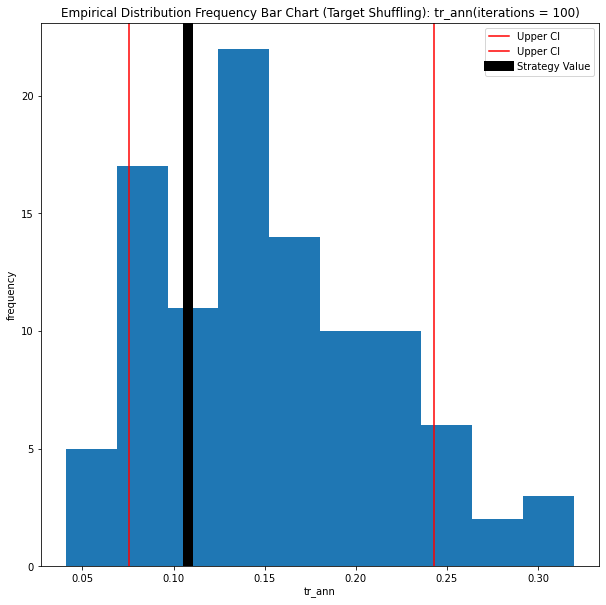

Empirical probability value of the strategy: tr_ann:0.25


<Figure size 432x288 with 0 Axes>

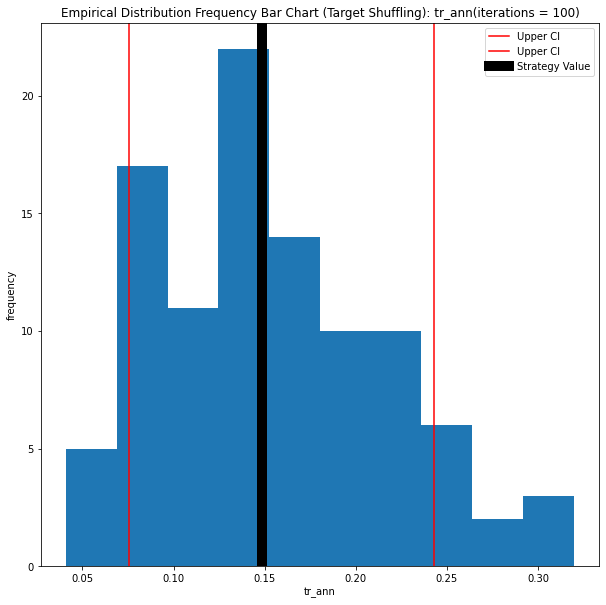

Empirical probability value of the strategy: tr_ann:0.53


In [281]:
# check the performance of the simultation using target shuffling lite, to form an empirical distributon of returns
# simulation...
target_shuffling_chart(dt_target_shuffling_dist, df_lin_sec_cagr)
# benchmark
target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

#### Bias Alert: Certainty bias

Any opinion offered about the probability, likelihood, certainty, or similar property for a hypothesis cannot be derived from statistical methods alone. In particular, significance tests and confidence intervals do not by themselves provide a logically sound basis for concluding an effect is present or absent with certainty or a given probability. This point should be borne in mind whenever one sees a conclu
sion framed as a statement of probability, likelihood, or certainty about a hypothesis. Information about the hypothesis beyond that contained in the analyzed data and in conventional statistical models (which give only data probabilities) must be used to reach such a conclusion; that information should be explicitly acknowledged and described by those offering the conclusion. Bayesian statistics offers methods that attempt to incorporate the needed information directly into the statistical model; they have not, however, achieved the popularity of P values and confidence intervals, in part because of philosophical objections and in part because no conventions have become established for their use.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877414/

#### Bias Alert: Endogenous bias
Endogeneity bias is not a simple violation and there is no easy statistical solution. It has serious consequences for outcomes, where in the presence of endogenous variables OLS learns biased and inconsistent parameters. P-values can be seriously misleading. All it takes is one endogenous variable to seriously distort ALL OLS parameters.
https://artnet.unescap.org/tid/artnet/mtg/gravity09_tues3.pdf

One potentially concerning endogeneity is self-fulfilling prophecy of factor investing, where stocks with high correlations to commonly used factors would cause investments in those stocks, causing price appreciation, affirming that the correlations with those factors caused the price rises.


## 3b. Factor Approach with Non-linear Regression

We now examine using machine learning tools, applied to a traditional quantative framework.
Traditional linear factor approaches, after Fama and French, assume persistent long-run returns of factors, and that a stock's loadings to these factors can be (linearly) mutliplied into factor returns to find their expected return. This is likely to be a flawed assumption as stock returns do not move in straight lines with respect to factor returns. Instead of keeping this assumption, we can add a nonlinear element to the relationship between our stocks' factor loadings and returns. We can train a ML model, in this case a neural net, to find a nonlinear function to fit all of our $N$ stocks' $K$ loadings, $\beta_ij$, to all their returns, $R_{it}$:

$$
R_{it} =\overset{̃}{f}_{j=1}(β_{i1}, β_{i2}, …, β_{iK}, f_{i1}, f_{i2}, …, f_{iK})
$$

Where $R_{i}$ is the return of stock $i$ at time $t$, $\beta$ is the exposure (loading) of stock $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 


To approximate the function $\overset{̃}{f}()$ is substantially more complex than simply assuming a linear relationship as factor models dosince it requires both the determination of this complex function.
While we may be shedding an oversimplistic assumption linear models make, we are now open to all sorts of biases in constructing our approach.

We will use an MLP neural net. To avoid ovefitting of neural net, ML is typically separated into a train and test data. Additionally, we are taking on much more complexity with this nonlinear features, with many hyperparameters needing to be specified, such as the size of the hidden layer, activation functions to choose, learning rate, and so on. The following neural net has been heuristically tuned, ie by trial and error, and this process took about 30minutes to complete. If you try changing the settings in the MLPRegressor's fit function yourself, you will see how variable the predictions are from this model. There is huge sensitivity to the typs of normalization use, the activation function used and so on. All this implies a lack of stability. Our message: avoid complex models to avoid biases. 



The MLP we will use has the following architecture, where the 11 input units relate to our 6, stock level factor coefficients (ie 5 $β$s, one $α$), and 5 corresponding factor returns over the longer run $f$. The architecture is shown with on hidden-layer, of 5 hidden units, and one output $R$.

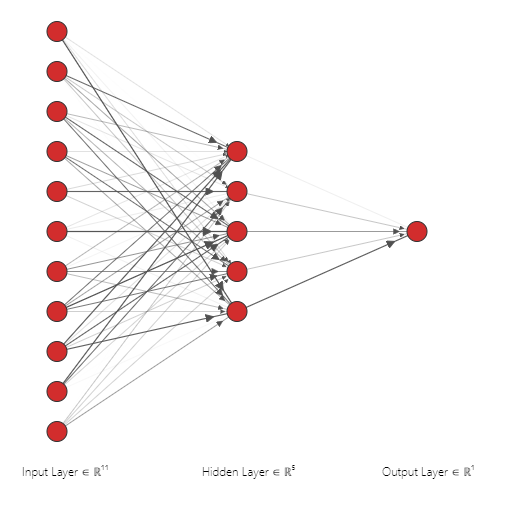

### Bias Alert: Normalization Data Snooping bias

For neural nets we almost always need to normalize (or standardize) the input data. There is room for a weak form of data snooping bias though, in historic simulations. 
We can either normlize by row (ie across a given stock's datapoints), so that each column is in proportion to the row. Or we can normlize by column. 

For stock selection applications row level normalization makes less sense, because taking PE ratio as an example, you want to compare one stock's PE ratio versus the PE ratio of all others; ie column normalize. It makes little sense to row normalize, where a stock's PE is scaled against the same stock's EBITDA/EV.  
The bias arises when we column normalize (or standardize) training data to train our model, and then pass in new data for forecasting, which may contain different min and maxes in each column. In this case all the column scalings will slightly change if the min max range changes from the training data.
In this case we can either live with the inaccuracy, or save the min-max training range and normalize the new data to the training range, capping the min/max at the training min/max, or allowing the min/max to exceed the -1/+1 range typically used for min/max scaling.


### Bias Alert: Repeated testing (multiplicity) bias

Complex machine learning approaches generally have many hyperparameters, such as neural nets, with the number of hidden nodes, the learning rate, optimizer used, activation function and so on. It is standard practices to conduct a grid search of these hyper parameters, known as hyperparameter tuning, until we find the optimum comdination. This is a problem if we are hypothesis testing the results of our model, for instance sampling the R2, and F-stat of the goodness of fit of our prediction, because the p-val is calculated to assume the probability of one test being conducted. This is known as multiplicity bias.   

Applying many tests in a single study results in an increased probability of detecting a significant finding just by chance (the problem of multiplicity). It then discusses some of the methods that have been proposed for correcting for multiplicity, including single-step procedures (e.g., Bonferroni); multistep procedures, such as those of Holm, Hochberg, and Šidák; false discovery rate control; and resampling approaches. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3015194/

### 3b i) Utility Functions: Calculate stock returns, Prep data for training/predicting

In this section we declare the function to calculate stock returns we will need as the $y$ variable for our neural net function: stock_rets_get.
We also need a function to generate the 11 inputs to the neural net: nonlinfactor_er_func_prep_data

In [282]:
def stock_rets_get(df_tb3ms: pd.DataFrame,
                    df_sec_rets: pd.DataFrame,
                    date_start: int,
                    date_end: int,
                    window_size: int = 36) -> pd.DataFrame:
  '''
  Calculate security returns on the same term as the factor loadings.
  This will be the input for our ML model.
  for securities with zero values in their history, remove them

  Args:
      df_tb3ms: DataFrame containing time series of 3m risk free rate
      ols_betas_final: DataFrame containing factor loadings for all securities
      date_start: training time window start period
      date_end: training time window end period
      window_size: Factor lodings calculated over what period?
      
  Returns:
      df_all_stock_returns: stock returns, cols are stocks, rows are time points between date_start and date_end; returns annualized over window_size

  '''

  # sanity
  if df_sec_rets.shape[0] < date_start + window_size: 
    raise TypeError("df_sec_rets.shape[0] < date_start + window_size")
  if df_sec_rets.shape[0] < date_start: 
    raise TypeError("df_sec_rets.shape[0] < date_start")
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 

  # NB: elements of the dict = time periods. The element numbers corrspond 
  # with row numbers in all other DatFrames in this note book (eg t=1, it t=1 in all other structures)
  df_all_stock_returns = pd.DataFrame(np.zeros((date_start-date_end, df_sec_rets.shape[1])))
  df_all_stock_returns.index = df_sec_rets.index[date_end:date_start]

  z = 0
  for i in range(date_start, date_end, -1):
    # Calc stock returns, annualized
    sec_returns = df_sec_rets.iloc[i:i+window_size, :].sort_index(ascending=True)
    
    #Ignore any entries with zeros
    sec_returns = sec_returns.replace(to_replace=0, value=np.nan)
    ignore_cols = ~df_sec_rets.isna().max(axis=0)
    
    sec_returns = 1 + sec_returns.loc[:,ignore_cols]   
    sec_returns = sec_returns.loc[:,ignore_cols].prod(axis=0)
    
    # Assume monthly data, annualize
    if (window_size > 12):
      # Supress warnings here...
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sec_returns.loc[ignore_cols] = sec_returns.loc[ignore_cols] ** (12/(window_size)) - 1  
    else:
      sec_returns.loc[ignore_cols] = sec_returns.loc[ignore_cols] - 1
    
    # All stock returns...
    df_all_stock_returns.iloc[z, ignore_cols.T] = sec_returns.T
    z += 1  
  
  return df_all_stock_returns

# Run function and get all factors loadings for all time periods
df_stock_returns = stock_rets_get(df_tb3ms=df_tb3ms,
                                        df_sec_rets=df_sec_rets,
                                        date_start = 1,
                                        date_end = 0,
                                        window_size=36)


It is a great help to have a function that wraps up the preparation of our data for training and predicting. The following function does this, where we can pass in our raw data and have it shaped for purpose.

In [283]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def nonlinfactor_er_func_prep_data(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_end: int,
                     func_training_period: int = 1,
                     forecast_ahead: int = 6,
                     window_size: int = 36) -> (pd.DataFrame, pd.DataFrame):

  '''
  Prepare data for training, testing and predicting from the nn. 
  **For training forecast_ahead > 0**
  **For prediction forecast_ahead = 0**
  NB: This look ahead from date_end! Data snooping risk!! 

  Args:
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      date_end: training time window end period
      func_training_period: pass 1 for predictions, >=1 for training. How many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end
      forecast_ahead: how many periods ahead are we predicting. Set this to 0 if we need data to predict.
      window_size: return window to use when calculating stock and factor returns.
      
  Returns:
      X: X data used to train/test/predict
      y: X data used to train/test/predict
  '''

  # sanity
  if func_training_period <1:
    raise TypeError("func_training_period <1")  
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 
  if (func_training_period < 0) | (func_training_period > df_sec_rets.shape[0]):
    raise TypeError("(func_training_period < 0) | (func_training_period > df_sec_rets.shape[0]") 
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 

  # Built training data over thei many periods: func_training_period
  # The time points to load are limited by the dtaa we have. Build X and y for window_size, func_training_period, else the longest period available...
  X = pd.DataFrame()
  y = pd.DataFrame()
  for t in range(date_end+forecast_ahead, date_end+forecast_ahead+func_training_period):

    #================================
    # Get data components for X at time t: df_stock_factor_loadings, factor_excess_returns; 
    # and y: stock_returns
    #================================
    # X data...
    stock_factor_loadings, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                                  df_sec_rets=df_sec_rets, 
                                                  df_ff_factors=df_ff_factors, 
                                                  date_start=t+window_size, #<< Note we pass in the start date here
                                                  date_end=t,
                                                  test_complexity = False)  #<< Note we pass in the end date here

    # X data... Factor returns to assume
    factor_excess_returns = df_ff_factors.iloc[t-forecast_ahead:t+window_size-forecast_ahead, :].sort_index()
    factor_excess_returns = np.array(1+factor_excess_returns).prod(axis=0)
    factor_excess_returns.astype(float)
    # Annualize
    if(window_size > 12):
      # Supress warnings here...
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        factor_excess_returns = factor_excess_returns ** (12/(window_size))-1  

    # Deduct rf from stock level returns, as it will have been for factor returns
    rf_ret = df_tb3ms.iloc[t-forecast_ahead:t+window_size-forecast_ahead, :].sort_index()
    rf_ret.astype(float)

    # y data... Stock level returns ... forecast ahead by forecast_ahead periods
    stock_returns = df_sec_rets.iloc[t-forecast_ahead:t+window_size-forecast_ahead, :].sort_index()
    stock_returns.astype(float)
    
    # Adjust returns for r_fs
    for j in range(0, stock_returns.shape[1]-1):      
      stock_returns.iloc[:,j] = (1+stock_returns.iloc[:,j].values) / (1+rf_ret.iloc[:,0].values) -1  # subtract r_f from each monthly return      
    stock_returns = np.array(1 + stock_returns).prod(axis=0)

    # Annualize
    if(window_size > 12):
      # Supress warnings here...
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        stock_returns = stock_returns ** (12/(window_size))-1

    # Prep X and y at time for training nn 
    #================================
    # X...
    # Dimension X
    X_t = pd.DataFrame(np.zeros((stock_factor_loadings.shape[0]+df_ff_factors.shape[1], stock_factor_loadings.shape[1])))
    # For training we can have 1 or more time period using "_t" suffix; 
    # For predicting we must only have 1 time period and columns should NOT have a suffix
    if (func_training_period > 1):
      X_t.columns = [str(col) + '_' + str(t) for col in df_sec_rets.columns]
    else:
      X_t.columns = [col for col in df_sec_rets.columns]

    # Add stock loadings to X
    X_t.iloc[0:stock_factor_loadings.shape[0],:] = stock_factor_loadings.copy(deep=True) #dict is indexed off 1, DFs and arrays off 0
    X_t.astype(float)
    X_index = stock_factor_loadings.index + '_coef'

    # Add factor returns to X (duplicate for each stock)
    for j in range(0, stock_factor_loadings.shape[1]):
      X_t.iloc[stock_factor_loadings.shape[0]:, j] = factor_excess_returns
    X_index = X_index.append(df_ff_factors.columns + '_ret')
    X_t.index = X_index

    # y... 
    y_t = pd.DataFrame(stock_returns.copy()).T #dict is indexed off 1, DFs and arrays off 0
    # For training we can have 1 or more time period using "_t" suffix; 
    # For predicting we must only have 1 time period and columns should NOT have a suffix
    if (func_training_period > 1):
      y_t.columns = [str(col) + '_' + str(t) for col in df_sec_rets.columns]
    else:
      y_t.columns = [col for col in df_sec_rets.columns]
    y_t.index = ['ALL']
    
    # Refine X and y
    X_t = X_t.replace(to_replace=0, value=np.nan)
    y_t = y_t.replace(to_replace=0, value=np.nan)

    X_invalid_cols_to_drop = X_t.columns[X_t.isna().sum()>0]
    y_invalid_cols_to_drop = y_t.columns[y_t.isna().sum()>0]
    invalid_cols_to_drop = X_invalid_cols_to_drop.append(y_invalid_cols_to_drop)
    invalid_cols_to_drop = invalid_cols_to_drop.unique()   

    X_t = X_t.drop(columns=invalid_cols_to_drop)
    y_t = y_t.drop(columns=invalid_cols_to_drop)      
    
    # Add X and y at time t to the master X, y
    X = pd.concat((X, X_t), axis=1) 
    y = pd.concat([y, y_t], join = 'outer', axis = 1)

  return X.T, y.T

# train nn 
nlf_X, nlf_y = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              func_training_period=1,
                                              forecast_ahead=6,
                                              window_size=24)


### 3b. ii) Train, and Forecast Functions

Now we need functions to train our neural net, and to provide the final forecast of stock returns in a given time period. 
We will need these function to generate expected returns which will feed into our trade generating function, decaled earlier, and our simulation function, declared earlier.

p-value may not be accurate for N > 5000.


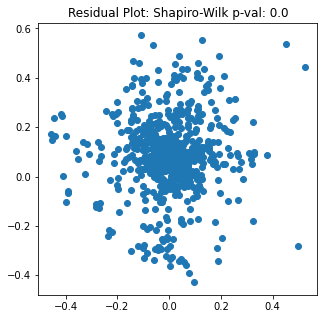

R2: 0.61; F-stat: 106.65


In [284]:
from sklearn.metrics import r2_score
from scipy.stats import f

# Train er function
def nonlinfactor_train_er_func(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_end: int,
                     forecast_ahead: int = 6,
                     window_size: int = 36,
                     func_training_period: int = 60,
                     hidden_layer_sizes: list = [5],
                     plot_residual_scatter: bool = False) -> (object, np.array, np.array, np.array):
  '''
  Train the expected return function for the non-linear approach
  
  Args:
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      date_end: training time window end period
      forecast_ahead: how many periods ahead should the model be trained to forecast
      window_size: return window to use when calculating stock and factor returns.
      func_training_period: how many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end
      hidden_layer_sizes: neural net number of units in hidden layer.
      plot_residual_scatter: generate a graph of the residulas for the model
      
  Returns:
      nn_mod: trained sklearn MLP model object      
      X_nlf: X data used to train
      y_train: y data used to train
      y_hat: insample y_hat

  '''

  # Sanity
  if forecast_ahead <=0:
    raise TypeError('forecast_ahead must be <0 if you are training. Otherwise you will be data snooping...')

  # Prep data for training the nn  
  # NB: **the y returned may have invalid stocks missing
  X_nlf, y_nlf = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=date_end, # << Avoid data snooping
                                              func_training_period=func_training_period,
                                              forecast_ahead=forecast_ahead,
                                              window_size=window_size)

  # Normalize X data... and transpose...
  X_norm = StandardScaler().fit_transform(X_nlf)  

  # Spilt into train and test data
  #X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.3, random_state=None)
  X_train_norm = X_norm
  y_train = y_nlf

  # Train ANN... R = f(loadings;factor returns)
  nn_mod = MLPRegressor(hidden_layer_sizes=(hidden_layer_sizes),
                          max_iter=500, 
                          learning_rate_init=0.01, 
                          random_state=0, 
                          solver='lbfgs', #'adam', 
                          tol=0.001,  
                          activation='logistic') #'tanh', 'logistic'

  nn_mod = nn_mod.fit(X=X_train_norm, y=np.ravel(y_train)) 

  # Predict in sample
  y_hat = nn_mod.predict(X_train_norm)
  resid = y_train.values-y_hat
  
  # Optional ...
  if plot_residual_scatter == True:   
    # In sample prediction: Examine residuals for normality... 
    # NB: The null hypothesis (H0) states that the variable is normally distributed, 
    # and the alternative hypothesis (H1) states that the variable is NOT normally distributed.  
    sw_stat, sw_p = shapiro(resid)
    
    # square plot def
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(y_train.iloc[:,0]-y_hat, y_hat)        
    plt.title('Residual Plot: Shapiro-Wilk p-val: ' + str(round(sw_p, 2)))
    plt.show()   

    # Summary stats
    r2 = r2_score(y_true=y_train.values, y_pred=y_hat)
    #F=R2/k(1−R2)/(n−k−1)
    f_stat = r2/(X_norm.shape[1]*(1-r2)/(X_norm.shape[0]-X_norm.shape[1]-1))    
    
    print('R2: ' + str(round(r2, 2)) + '; F-stat: ' + str(round(f_stat, 2)))

  return nn_mod, X_nlf, y_train, y_hat

# train nn 
nn_model, X_nlf, y_train_nlf, y_hat_nlf = nonlinfactor_train_er_func(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              forecast_ahead=6,
                                              window_size=36,
                                              func_training_period=12,
                                              plot_residual_scatter=True)


### Bias Alert: Complexity Bias
Using a complex model such as a neural net may be appealing but number of parameters the model needs to have trained may exceed our rule of thumb for complexity. It may in anycase, not an ideal learner to apply, if a more simple approach achieves a similar result. 


In [285]:
# count the number of parameters in the MLP
param_count = 0
for i in range(0, nn_model.coefs_.__len__()):
  param_count += nn_model.coefs_[i].shape[0]


# Sanity Check: Biases ************************
failed, _, _ = bias_complexity_check_regression(no_of_instances=36, # Try to use  36month window to train the MLP
                                    no_of_features=X_nlf.shape[1]-1, # Do not count intercept
                                    no_of_parameters=param_count) 
if failed == True:
  print("************ Complexity bias warning ***************")  
# Sanity Check: Biases ************************

************ Complexity bias warning ***************


In [286]:
# Forecast the expected return of all stocks at a single time point.
def nonlinfactor_forecast_er(nn_model: object,                             
                            df_tb3ms: pd.DataFrame,
                            df_sec_rets: pd.DataFrame,
                            df_ff_factors: pd.DataFrame,
                            date_end: int,
                            window_size: int = 36) -> pd.DataFrame:

  '''
  Forecast expected return for a specific time window ending date_end, using the non-linear approach.
  NB: Forecasts n number of periods into the future is given by the training function

  Args:
      nn_model: MLPRegression object from sklearn
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      date_end: training time window end period
      window_size: return window to use when calculating stock and factor returns.
      
  Returns:
      e_r: expected returns for all stocks at time point date_end
  '''

  # sanity
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 

  # Factor returns to assume, annualized...
  factor_excess_returns = df_ff_factors.iloc[date_end:date_start, :].sort_index()
  factor_excess_returns = np.array(1+factor_excess_returns.iloc[date_end:date_start, :]).prod(axis=0)

  # Annulize monthly returns
  if ((window_size) > 12):
    # Supress
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      factor_excess_returns = factor_excess_returns ** (12/((window_size)))-1
  else:
    factor_excess_returns = factor_excess_returns-1
    
  # Prep data for training the nn  
  # Only use the latets period: func_training_period=1
  #==================================='  
  X_test, y_test = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=date_end,
                                              forecast_ahead=0, # <<< Set to zero to predict!
                                              window_size=window_size,
                                              func_training_period=1)

  X_test_index = X_test.index.to_list()

  #*Quirk ... Sklearn needs 2D array to predict - insert zero row...
  blank_row = np.repeat([999999], X_test.shape[1])
  X_test = np.vstack((X_test, blank_row))

  # Stock Forecast E(R)_i,t+h
  e_r = nn_model.predict(X_test)

  # r_f...
  e_r[(e_r!=0)] = e_r[(e_r!=0)] + df_tb3ms.iloc[date_end,0]

  # *Remove the added instance (99999) above...
  e_r = pd.DataFrame(e_r)
  e_r = e_r.iloc[0:-1,:]  
  e_r.index = X_test_index

  return e_r

# Run 
nlf_er = nonlinfactor_forecast_er(nn_model=nn_model, 
                                    df_tb3ms=df_tb3ms, 
                                    df_sec_rets=df_sec_rets,
                                    df_ff_factors=df_ff_factors,
                                    date_end=19,
                                    window_size=36)



It is also possible to examine the MLP model, using SHAP. Which inputs most influenced the return outcomes in the period we used to training the model?

In [287]:
# We may need to install shap..
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [288]:
import shap

# SHAP XAI on the training data
X_nlf_sample = shap.sample(X_nlf, 100)
explainer = shap.KernelExplainer(nn_model.predict, X_nlf_sample)

# Supress warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  shap_values = explainer.shap_values(shap.sample(X_nlf, 100))
  shap.summary_plot(shap_values, X_nlf_sample.values, feature_names=X_nlf_sample.columns)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [289]:
df_sec_rets

TICKER,ZEUS-US,WTBA-US,WRLD-US,VRTS-US,VMO-US,VCV-US,SCHL-US,SAR-US,RVT-US,RGR-US,...,CHN-US,CENX-US,BUI-US,BPT-US,BNY-US,BME-US,APOG-US,AMOT-US,AMN-US,AAN-US
DATE,,,,,,,,,,,,,,,,,,,,,
202207,0.154563,0.068611,-0.013052,0.215350,0.055967,0.027597,0.308590,-0.016688,0.132427,0.038963,...,-0.123473,0.070556,0.054973,-0.058160,0.044241,0.038584,0.067074,0.179510,0.024884,-0.105155
202206,-0.246415,-0.043615,-0.241980,-0.112322,-0.035206,-0.031999,-0.041567,-0.078458,-0.069689,-0.062454,...,0.161314,-0.375424,-0.023252,0.029160,-0.068359,-0.026415,-0.057212,-0.069275,0.132198,-0.251060
202205,-0.002039,0.028350,-0.215357,0.087492,0.036562,0.039670,0.018453,0.038702,-0.003245,0.006519,...,0.012859,-0.300533,-0.040708,0.528824,0.068916,0.014529,-0.049514,0.009310,-0.008696,-0.047248
202204,-0.107384,-0.081220,-0.016316,-0.255785,-0.084864,-0.040012,-0.081466,-0.061629,-0.092996,-0.021115,...,-0.104336,-0.358799,-0.065780,-0.069235,-0.080139,-0.042852,-0.072903,-0.184316,-0.063069,0.022410
202203,0.436683,-0.058478,-0.023566,-0.002618,-0.030902,-0.049852,-0.042776,0.011614,-0.005423,-0.026799,...,-0.084935,0.113887,0.067291,0.187153,-0.054363,0.059348,0.053029,-0.142307,-0.017053,-0.038564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201303,0.156265,0.002710,0.091106,0.108744,-0.018053,-0.042989,-0.114618,-0.032897,0.030015,-0.064399,...,-0.020969,-0.045062,0.019091,0.041412,-0.064600,0.027654,0.122528,-0.014286,0.122695,0.050934
201302,-0.015221,0.009116,0.014829,0.127508,-0.027509,0.012045,0.014835,-0.043820,0.021379,0.075635,...,-0.044949,-0.058140,0.016326,0.032985,-0.008695,0.025848,0.058740,0.042285,0.160494,-0.079595
201301,-0.051039,0.026902,0.040102,0.232098,0.032816,0.007656,0.007579,0.155844,0.080477,0.118282,...,0.049510,-0.018444,0.076579,0.166949,0.023306,0.063169,0.020025,0.021212,0.051948,0.048444


Now we can implement a function that applies the forecasting function over the study term, ready for historic simulation testing.

In [290]:
# Calc all expected returns for all stocks and all time periods.
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def nonlinfactor_forecast_all_er(df_benchmark_trades: pd.DataFrame,
                                 df_tb3ms: pd.DataFrame,
                                df_sec_rets: pd.DataFrame,
                                df_ff_factors: pd.DataFrame,
                                forecast_ahead: int = 6,
                                window_size: int = 36, 
                                func_training_period: int = 24) -> (pd.DataFrame, object):

  '''
  Forecast expected return for all time-windows starting at date_start, using the non-linear approach. 

  Args:
      df_benchmark_trades: only calculate er for benchmark positions
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      forecast_ahead: how many periods ahead are we forecasting?
      window_size: return window to use when calculating stock and factor returns.
      func_training_period: window to use to train the nn function of loadings and factor returns to expevcted return ...
      
  Returns:
      df_all_er: expected returns forecast for all stocks across all time periods
  '''

  # E(R) for each stock, in each time period
  df_all_er = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_all_er.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_all_er.columns = df_sec_rets.columns[0:df_sec_rets.shape[1]] #.astype(int)
  #
  df_stock_SW_pval = df_all_er.copy(deep=True)

  # start period?
  start_period = min(df_benchmark_trades.shape[0], df_ff_factors.shape[0])  

  # Progress
  pbar = tqdm()
  pbar.reset(total=start_period-max(func_training_period,window_size)-2)  # initialise with new `total`

  #Step through time... earliest to latest-forecast_ahead.
  for t in range(start_period-max(func_training_period,window_size)-forecast_ahead-1, -1, -1):
    
    # Progress
    pbar.update()

    # Run our function, returning only the result object
    df_stock_factor_loadings, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets, 
                                              df_ff_factors=df_ff_factors, 
                                              date_start=t+window_size, #<< Note we pass in the start date here
                                              date_end=t,
                                              test_complexity = False)  #<< Note we pass in the end date here
    
    
    # Get function of security returns = f(loadings and factor returns)
    nn_mod, _, _, _ = nonlinfactor_train_er_func(df_tb3ms = df_tb3ms, 
                                              df_sec_rets = df_sec_rets,
                                              df_ff_factors = df_ff_factors,
                                              date_end = t,
                                              forecast_ahead = forecast_ahead,
                                              window_size = window_size,
                                              func_training_period = 1)
    
    # Get forecast returns...
    nlf_er = nonlinfactor_forecast_er(nn_model=nn_model, 
                                      df_tb3ms=df_tb3ms, 
                                      df_sec_rets=df_sec_rets,
                                      df_ff_factors=df_ff_factors,
                                      date_end=t,
                                      window_size=window_size)

    # Forecasts may not have the the cols/stocks of df_sec_rets (invalid cols/stocks will be dropped)
    row_nlf_er = nlf_er.T
    nlf_er_all_cols = pd.DataFrame(np.zeros((1,df_sec_rets.shape[1])))
    nlf_er_all_cols.columns = df_sec_rets.columns
    nlf_er_all_cols[row_nlf_er.columns] = row_nlf_er
    
    df_all_er.iloc[t,:] = nlf_er_all_cols

    # Set zeros to nan
    def zero_to_nan(x):
      if x == 0:
        x = np.nan
      return x

    df_all_er = df_all_er.applymap(zero_to_nan) 

  return df_all_er, nn_mod

# Run the function with our data
df_nlf_all_er, nn_mod_latest = nonlinfactor_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                            df_tb3ms=df_tb3ms, 
                                                            df_sec_rets=df_sec_rets,
                                                            df_ff_factors=df_ff_factors,
                                                            window_size= 36, 
                                                            func_training_period=1)

0it [00:00, ?it/s]

### 3b) iii) Non-linear Factor Model Applied Over Time
Using our simulation functions decalred earlier, we can run a simulation using our non-linear factor model.

Finally we run our stock selection and simulation functions, applied to the non-linear factor approach...

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


,Analytics
Total Return (TR)(annualized),0.166489
Standard deviation (SD) (annualized),0.220630
Sharpe Ratio (TR/SD),0.754606
Hit rate (monthly),0.657895


,Descriptive Stats
Mean (TR),0.015229
Median (TR),0.013847
Variance (TR),0.004056
Skewness (TR),-0.157135
Kurtosis (TR),0.997843


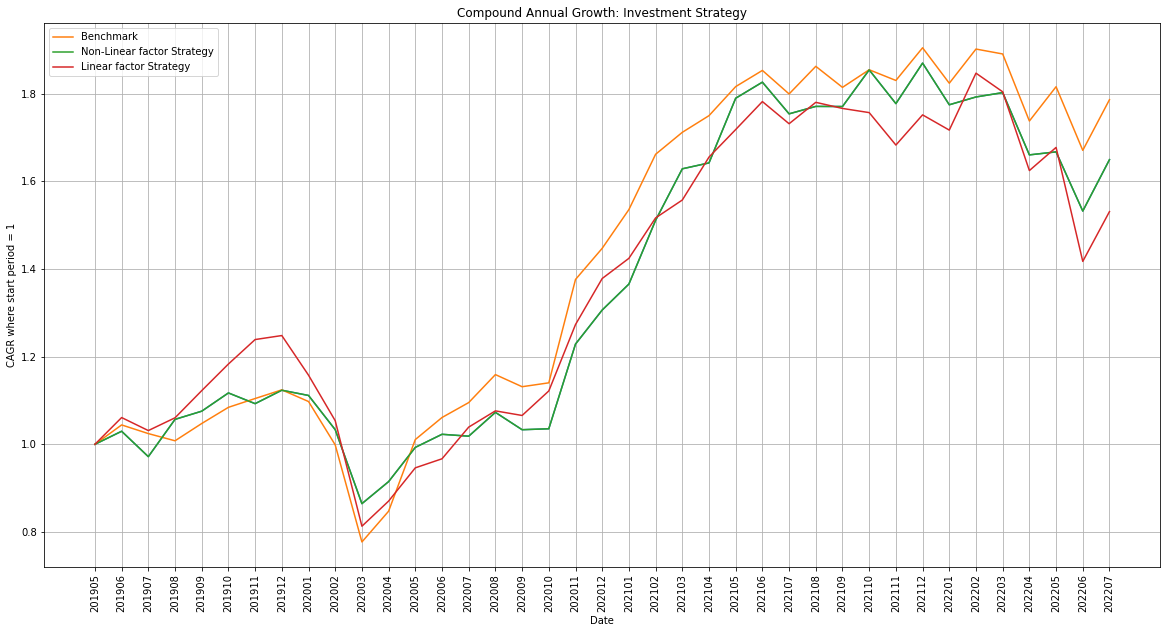

In [308]:
# Run the function to establish simple trades
df_nlf_trades = trades_topquantile_generate(df_all_er=df_nlf_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(start_period_trades(df_trades)),int(start_period_trades(df_nlf_trades)),int(start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_non_lin_sec_cagr, p = run_sim(df_trades=df_nlf_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = sim_chart(df_non_lin_sec_cagr)
sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
p.legend()
p.show()

<Figure size 432x288 with 0 Axes>

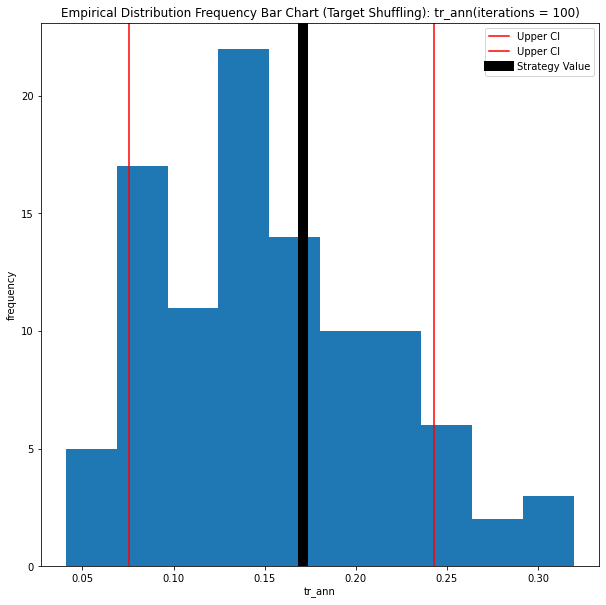

Empirical probability value of the strategy: tr_ann:0.65


<Figure size 432x288 with 0 Axes>

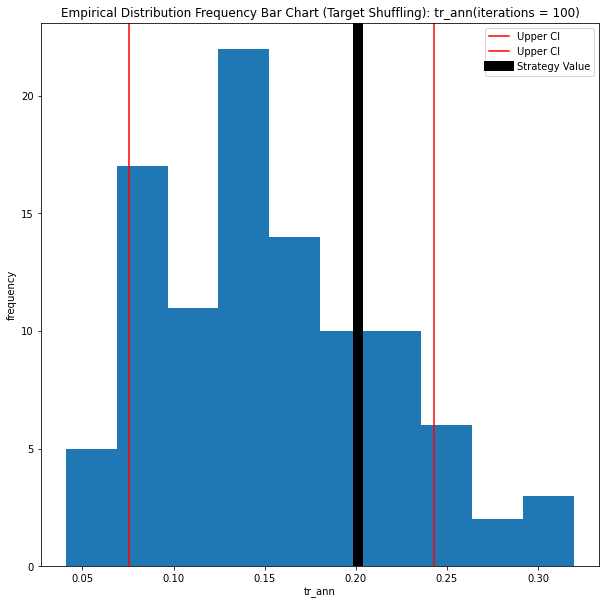

Empirical probability value of the strategy: tr_ann:0.76


In [310]:
# check the performance of the simultation using target shuffling lite, to form an empirical distributon of returns
# simulation...
target_shuffling_chart(dt_target_shuffling_dist, df_non_lin_sec_cagr)
# benchmark
target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

## 3c. Interpretable Machine Learning Approach


Now, rather than using a ML retrofit to traditional quantitative investing approach, we will use a purpose designed machine learning approach which is interpretable, and associative (a weaker take on causality, avoiding frequentist approaches that might just identify correlation not causation). This is a form of symbollic artificial intelligence (SAI), where the symbols are actually investment-rules. This ML approach will automatically find associations between our input features and our ground truth.






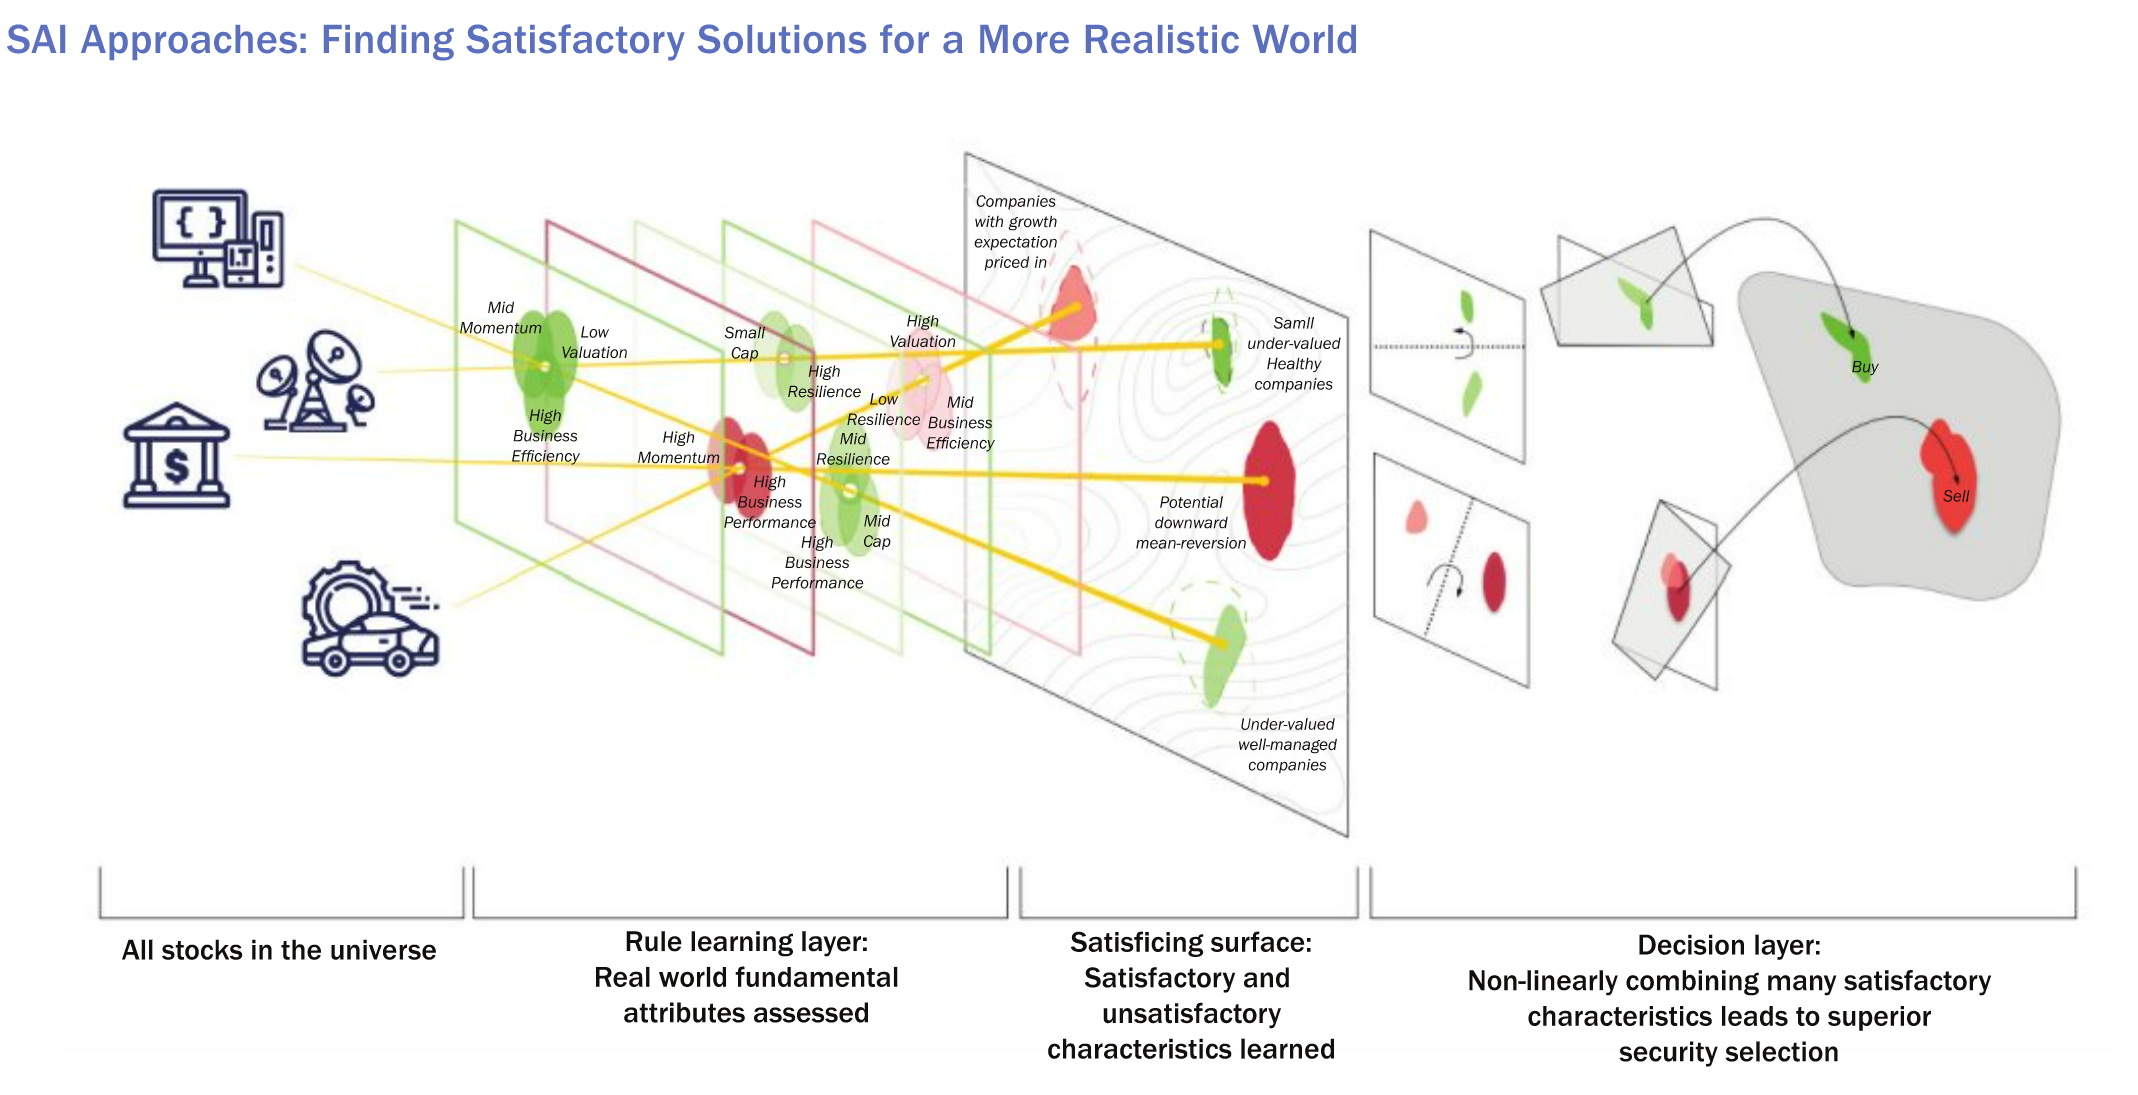

### Mitigating Biases: Rules based ML
Rules based ML, or symbolic ML, can avoid many of the biases in parametric investment models, and address the problem of explainability in ML models. Rules can also be learned using as complex an ML pipeline as is appropriate. 

#### Nonparametric
Rules based stock selection is considered to be non parametric (although rule learning may be parametric), assuming no distribution, thus avoiding many of the violations of parametric models as a result. Unlike many forms of machine learning, rules are also interpretable, allowing stake holders to review investment rules to gain some understanding of the way a model is operating. 

#### Stock Selection as a Classification Problem
Rules are also most easily considered as a classification problem, which requires less complexity than regression problems. As a classification problem, fewer data points and more features are able to be used under our complexity rules of thumb.
Certain rule learning approaches can be applied to a high number of features, avoiding the need for explicit dimensionality reduction, which itself can introduce further inductive biases and assumptions (eg PCA).

#### "Weak" causality
Rather than using traditional frequentist statistics (such as t-stats of OLS betas), SAI learns rules based on associations with hints of causality. For example, odds ratios, confidence scores and "lift" can all be used to learn SAI's rules. Lift determines the relative probability of a "treatment" on an outcome:

$ lift = \frac{P(return>x|A)}{P(return>x, A)} $

Where $x$ is the desired return threshold, $P(return>x|A)$ is the conditional probability of a stock with a return above the required return threshold also having a feature $A$, $P(return>x, A)$ is the random chance a stock with a return above the required return threshold also has a feature $A$.


The SAI approach generates rules we can use to select stocks.


Install the SAI package...

In [311]:
!pip install investsai -q

Import it...

In [ ]:
from investsai.sai import SAI 


### 3c. i) Utility Function: Prep data for training/predicting

For SAI our data preparation function to generate X and y variables is different. Firstly, the X variables are features, ie anything that might drive the model to find a better outcome. This can include traditional factors, but can also include fundamentals, valuations, ratios, sentiment scores, macro data affecting the country of a stock, and just about any other numeric attribute relevant to stock selection.
Rule learning includes feature selection, where the rules can be applied to potentially thousands of input features. Traditional quant models, in contrast, require explicit dimensionality reduction and the specfic selection and/or engineering of factors.


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def sai_er_func_prep_data(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     dic_fundamentals: dict,                     
                     date_end: int,
                     func_training_period: int = 1,
                     buysell_threshold_quantile: float = 0,
                     forecast_ahead: int = 6,
                     window_size: int = 36) -> (pd.DataFrame, pd.DataFrame):

  '''
  Prepare data for training, testing and predicting from the SAI model. 
  **For training forecast_ahead > 0**
  **For prediction forecast_ahead = 0**
  NB: This look ahead from date_end! Data snooping risk!! 

  Args:
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      dic_fundamentals: disctionary containing fundamentals
      date_end: training time window end period
      func_training_period: pass 1 for predictions, >=1 for training. How many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end
      buysell_threshold_quantile: which quantile of return should we consider a "buy": top 10tb, top 30th percentile
      forecast_ahead: how many periods ahead are we predicting. Set this to 0 if we need data to predict.
      window_size: return window to use when calculating stock and factor returns.
      
  Returns:
      X: X data used to train/test/predict
      y: X data used to train/test/predict
  '''

  # sanity
  if func_training_period < 1:
    raise TypeError("func_training_period < 1: must have at least 1 training period")  
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 
  if (func_training_period < 0) | (func_training_period > df_sec_rets.shape[0]):
    raise TypeError("(func_training_period < 0) | (func_training_period > df_sec_rets.shape[0]") 
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 
  
  # Validate: get all dates and tickets from fundamentals 
  check_index = None 
  check_cols = None
  for fundamentals_df in dic_fundamentals:
    if check_index is None:
      check_index = list(dic_fundamentals[fundamentals_df].index)
    else:
      if list(dic_fundamentals[fundamentals_df].index) == check_index:
        pass
      else:
        raise TypeError('Data mismatch: A df in the fundamentals dictionary has a mismatced index :' + fundamentals_df)

    if check_cols is None:
      check_cols = list(dic_fundamentals[fundamentals_df].columns)
    else:
      if list(dic_fundamentals[fundamentals_df].columns) != check_cols:
        raise TypeError('Data mismatch: A df in the fundamentals dictionary has mismatced columns :' + fundamentals_df)

  all_ticker = list(set(check_index)) # get unique
  all_dates = list(set(check_cols)) # get unique 

  # Built training data over thei many periods: func_training_period
  # The time points to load are limited by the dtaa we have. Build X and y for window_size, func_training_period, else the longest period available...
  dic_loadings = dict()
  master_X = pd.DataFrame()
  master_y = pd.DataFrame()

  for t in range(date_end+forecast_ahead, date_end+forecast_ahead+func_training_period):  

    #================================
    # Get data components for X at time t: df_stock_factor_loadings, factor_excess_returns; 
    # and y: stock_returns
    #================================
    
    # y variable...
    #=============================
    y_t = pd.DataFrame(np.zeros((len(all_ticker), 0)))
    # Deduct rf from stock level returns, as it will have been for factor returns
    rf_ret = df_tb3ms.iloc[t:t+forecast_ahead, :].sort_index()
    rf_ret.astype(float)

    # y data... Stock level returns ... forecast ahead by forecast_ahead periods
    stock_returns = df_sec_rets.iloc[t:t+forecast_ahead, :].sort_index()
    stock_returns.astype(float)        
    
    # Adjust returns for r_fs
    for j in range(0, stock_returns.shape[1]-1):      
      stock_returns.iloc[:,j] = (1+stock_returns.iloc[:,j].values) / (1+rf_ret.iloc[:,0].values)-1  # subtract r_f from each monthly return      
    stock_returns = np.array(1 + stock_returns).prod(axis=0)

    # Annualize
    if(window_size > 12):
      # Supress warnings here...
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        stock_returns = stock_returns ** (12/(window_size))-1

    #Add Ticker and Date columns
    y_t = pd.DataFrame(stock_returns)
    y_t.columns = ['y']

    col_date = [df_sec_rets.index[t] for i in range(0, y_t.shape[0])]
    y_t['date'] = col_date
    y_t['ticker'] = df_sec_rets.columns    

    # All dates  and tickers represented?
    # Supress warnings here...
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      missing_tickers = [tk for tk in all_ticker if tk not in y_t['ticker'].unique()]   
      for missing_ticker in missing_tickers:
        y_t.loc[y_t.shape[0]+1] = None
        y_t.loc[y_t.shape[0],'ticker'] = missing_ticker
        y_t.loc[y_t.shape[0],'date'] = df_sec_rets.index[t]

    # Add X and y at time t to the master X
    y_t['date'] = y_t['date'].astype(int)
    if func_training_period > 1:
      y_t['ticker'] = y_t['ticker'].astype(str) + "_" + str(t)
    else:
      y_t['ticker'] = y_t['ticker'].astype(str)
    y_t = y_t.set_index('ticker')

    # Convert y to a {1,0} classifier {buy, sell}
    buy_threshold = y_t[y_t.isna() == False]['y'].quantile(q=buysell_threshold_quantile)
    buy_mask = y_t['y'] >= buy_threshold
    
    # y class...
    y_class_t = y_t
    y_class_t['y'] = 0
    y_class_t.loc[buy_mask, 'y'] = 1

    # Add to master
    master_y = pd.concat((master_y, y_t), axis=0)
    
    # X variable... NO DATA SNOOPING...
    #=============================  
    # X data...
    stock_factor_loadings, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                                  df_sec_rets=df_sec_rets, 
                                                  df_ff_factors=df_ff_factors, 
                                                  date_start=t+forecast_ahead+window_size, #<< Note we pass in the start date here
                                                  date_end=t+forecast_ahead+1,
                                                  test_complexity = False)  #<< Note we pass in the end date here
    # X...
    # Dimension X
    X_t = pd.DataFrame(np.zeros((stock_factor_loadings.shape[1], stock_factor_loadings.shape[0])))

    # Add stock loadings to X
    X_t = stock_factor_loadings.T.copy(deep=True) 
    X_t.astype(float)
    X_t.columns = stock_factor_loadings.index

    # Refine X
    X_t = X_t.replace(to_replace=0, value=np.nan)

    #Add Ticker and Date columns    
    X_t['date'] = col_date
    X_t = X_t.reset_index()
    X_t.columns = X_t.columns.str.lower() 

    # All dates  and tickers represented?
    # Supress warnings here...
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      #
      missing_tickers = [tk for tk in all_ticker if tk not in X_t['ticker'].unique()]   
      for missing_ticker in missing_tickers:
        X_t.loc[X_t.shape[0]+1] = None
        X_t.loc[X_t.shape[0],'ticker'] = missing_ticker
        X_t.loc[X_t.shape[0],'date'] = df_sec_rets.index[t]

    # Add X and y at time t to the master X    
    X_t['date'] = X_t['date'].astype(int)
    if func_training_period > 1:
      X_t['ticker'] = X_t['ticker'].astype(str) + "_" + str(t)
    else:
      X_t['ticker'] = X_t['ticker'].astype(str)
    
    X_t = X_t.set_index('ticker')
    master_X = pd.concat((master_X, X_t), axis=0)  
  
  # Final preps...
  # Drop na securities, 
  #======================================
  sai_y = master_y
  sai_X = master_X

  # Exclude all nas
  X_rows_to_kill = sai_X.loc[sai_X.isna().sum(axis=1)!=0].index.to_list()
  y_rows_to_kill = sai_y.loc[sai_y.isna().sum(axis=1)!=0].index.to_list()
  rows_to_kill = X_rows_to_kill + y_rows_to_kill
  rows_to_kill = list(set(rows_to_kill))

  rows_to_keep = [tk for tk in sai_X.index.to_list() if tk not in X_rows_to_kill]

  # Kill invalid secs from X and y
  sai_X = sai_X.loc[rows_to_keep]
  sai_y = sai_y.loc[rows_to_keep]

  # Drop dates
  sai_y = sai_y.drop('date', axis=1)
  sai_X = sai_X.drop('date', axis=1)

  return sai_X, sai_y

# train nn 
sai_X, sai_y = sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=6,
                                  window_size=24,
                                  func_training_period=3)



### 3c. ii) Train, and Forecast Functions

Now we need functions to train our SAI model and to provide the final outcome, which is a buy/sell decision for each stock in a given time period. 
We will need these functions to feed into our trade generating function, decaled earlier, and our simulation function, declared earlier.

In [ ]:
import sklearn.metrics as metrics

# Train er function
def sai_train_er_func(df_tb3ms: pd.DataFrame,
                      df_sec_rets: pd.DataFrame,
                      df_ff_factors: pd.DataFrame,
                      dic_fundamentals: dict,
                      date_end: int,
                      buysell_threshold_quantile: float = 0,
                      forecast_ahead: int = 6,
                      window_size: int = 36,
                      func_training_period: int = 1,
                      show_analytics: bool = False) -> (object, np.array, np.array,  np.array):
  '''
  Args:
    df_tb3ms: risk free rate
    df_sec_rets: stock level returns monthly
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
    dic_fundamentals: disctionary containing fundamentals
    date_end: training time window end period
    buysell_threshold_quantile: which quantile of return should we consider a "buy": top 10tb, top 30th percentile
    forecast_ahead: how many periods ahead are we predicting. Set this to 0 if we need data to predict.
    window_size: return window to use when calculating stock and factor returns.
    func_training_period: pass 1 for predictions, >=1 for training. How many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end    
    plot_residual_analytics: generate a data specific to the model

  Returns:
    sai_mod: trained SAI model object
    X: X data used to train
    y: y data used to train
    y_hat: insample y_hat

  '''

  # sanity
  if not(isinstance(df_tb3ms, pd.DataFrame)):
    raise TypeError("df_tb3ms can only be pandas DataFrame df")
  if not(isinstance(df_sec_rets, pd.DataFrame)):
    raise TypeError("df_sec_rets can only be pandas DataFrame df")
  if not(isinstance(df_ff_factors, pd.DataFrame)):
    raise TypeError("df_ff_factors can only be pandas DataFrame df")
  if not(isinstance(dic_fundamentals, dict)):
    raise TypeError("dic_fundamentals can only be dict")            
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 

  #================================ 
  # train SAI
  #================================
  # Input parameters
  params = {
  'q': 3,
  'parallel': True,
  'nb_workers': 2,
  'verbose': show_analytics
  }

  # Generate training data
  sai_train_X, sai_train_y = sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  df_ff_factors=df_ff_factors,
                                  dic_fundamentals=dict_sec_ff,
                                  date_end=date_end, #<< Training, No data snooping
                                  func_training_period=func_training_period,
                                  buysell_threshold_quantile=buysell_threshold_quantile,
                                  forecast_ahead=forecast_ahead, 
                                  window_size=window_size)

  # Train SAI... 
  #==========================
  sai_mod = SAI(params=params)
  sai_mod.fit(X=sai_train_X, y=sai_train_y)


  # Generate test data
  sai_test_X, sai_test_y = sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  df_ff_factors=df_ff_factors,
                                  dic_fundamentals=dict_sec_ff,
                                  date_end=date_end, #<< Training, No data snooping
                                  func_training_period=1,
                                  buysell_threshold_quantile=buysell_threshold_quantile,
                                  window_size=window_size) #<< Only use 1 period

  # Predict using only rules with a causal lift of >1
  #==========================
  y_hat = sai_mod.predict(X=sai_test_X,
                          metric='causal_lift', 
                          cutoff=1)
  
  y_hat = y_hat.sort_index()

  return sai_mod, sai_X, sai_y, y_hat

# Train our SAI model
sai_mod, sai_X, sai_y, sai_y_hat = sai_train_er_func(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0, #<< Training, No data snooping
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=6,
                                  window_size=36,
                                  func_training_period=12,
                                  show_analytics=True)



We can review the rules SAI has learned, where (mkt-rf_2, cma_1) indicates stocks need to satisfy "mkt-rf_2" and "cma_1": where "mkt-rf_2" indicates a stock must have MKT beta of the middle tercile (ie around the mean level within the stock universe considered), and must also have "cma_1", where the CMA factor loading of a stock needs to be in the highest CMA tercile in the universe considered.
We can also review the conditional success probability (cond_success_prob), odds ratio (odd_ratio) and lift (causal_lift) of each of our rules.

In [ ]:
sai_mod.rules

In [ ]:
# Forecast er function, requiring a causal_lift>1
def sai_forecast_er(sai_mod: object,
                      df_tb3ms: pd.DataFrame,
                      df_sec_rets: pd.DataFrame,
                      df_ff_factors: pd.DataFrame,
                      dic_fundamentals: dict,
                      date_end: int,
                      buysell_threshold_quantile: float = 0,
                      window_size: int = 36) -> (pd.DataFrame):
  '''
  Args:
    sai_mod: fully ini-ed and trained sai model object
    df_tb3ms: risk free rate
    df_sec_rets: stock level returns monthly
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
    dic_fundamentals: disctionary containing fundamentals
    date_end: training time window end period
    buysell_threshold_quantile: which quantile of return should we consider a "buy": top 10tb, top 30th percentile
    window_size: return window to use when calculating stock and factor returns.
    
  Returns:
    y_hat: insample y_hat

  '''

  #Ini
  func_training_period = 1

  # Get Data
  #================================  
  sai_test_X, sai_test_y = sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,  #<< Latest period
                                  func_training_period=1,
                                  buysell_threshold_quantile=buysell_threshold_quantile,
                                  forecast_ahead=0, #<< Latest period
                                  window_size=window_size) #<< Latest period
  
  # Predict using only rules with a causal lift of >1
  #==========================
  y_hat = sai_mod.predict(X=sai_test_X,
                          metric='causal_lift', 
                          cutoff=1)
  y_hat = y_hat.sort_index()

  #convert back to dimensions of df_sec_rets
  y_hat_final = pd.DataFrame(np.zeros((df_sec_rets.shape[1],0)))
  y_hat_final.index = df_sec_rets.columns    
  y_hat_final = y_hat_final.merge(y_hat, how='left', left_index=True, right_index=True)
  
  return y_hat_final

# Train our SAI model
sai_y_hat = sai_forecast_er(sai_mod=sai_mod,
                            df_tb3ms=df_tb3ms, 
                            df_sec_rets=df_sec_rets,
                            df_ff_factors=df_ff_factors,
                            dic_fundamentals=dict_sec_ff,                                  
                            date_end=0, #<< Training, No data snooping
                            buysell_threshold_quantile=0.75,
                            window_size=36)


In [ ]:
# Calc all expected returns for all stocks and all time periods.
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def sai_forecast_all_er(df_benchmark_trades: pd.DataFrame,
                      df_tb3ms: pd.DataFrame,
                      df_sec_rets: pd.DataFrame,
                      df_ff_factors: pd.DataFrame,
                      dic_fundamentals: dict,
                      date_end: int,
                      buysell_threshold_quantile: float = 0,
                      forecast_ahead: int = 6,
                      window_size: int = 36,
                      func_training_period: int = 1,
                      plot_residual_analytics: bool = False) -> (pd.DataFrame, object):

  '''
  Args:
      df_benchmark_trades: only calculate er for benchmark positions
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      dic_fundamentals: disctionary containing fundamentals
      date_end: training time window end period
      buysell_threshold_quantile: which quantile of return should we consider a "buy": top 10tb, top 30th percentile
      forecast_ahead: how many periods ahead are we predicting. Set this to 0 if we need data to predict.
      window_size: return window to use when calculating stock and factor returns.
      func_training_period: pass 1 for predictions, >=1 for training. How many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end    
      plot_residual_analytics: generate a data specific to the model      
      
  Returns:
      df_all_er: expected returns forecast for all stocks across all time periods
      sai_mod: the last sai model object
  '''
  
  # E(R) for each stock, in each time period
  df_all_er = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_all_er.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_all_er.columns = df_sec_rets.columns[0:df_sec_rets.shape[1]] #.astype(int)
  #
  df_stock_SW_pval = df_all_er.copy(deep=True)

  # start period?
  start_period = min(df_benchmark_trades.shape[0], df_ff_factors.shape[0])

  # Progress
  pbar = tqdm()
  pbar.reset(start_period-max(func_training_period, window_size,func_training_period)-1)  # initialise with new `total`

  #Step through time... earliest to latest.
  for t in range(start_period-max(func_training_period, window_size,func_training_period)-1, -1, -1):

    # Progress
    pbar.update()

    # Get function of security returns = f(loadings and factor returns)
    sai_mod, sai_X, sai_y, y_hat = sai_train_er_func(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0, #<< Training, No data snooping
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=6,
                                  window_size=36,
                                  func_training_period=12)
        
    # Generate E(R) from our stock level factor model...      
    e_r = sai_forecast_er(sai_mod = sai_mod,
                            df_tb3ms=df_tb3ms,
                            df_sec_rets=df_sec_rets,
                            df_ff_factors=df_ff_factors,
                            dic_fundamentals=dic_fundamentals,
                            date_end=t,
                            buysell_threshold_quantile=buysell_threshold_quantile,
                            window_size=window_size)
    
    # Only keep er values from benchmark 
    benchmark_mask = df_benchmark_trades.iloc[t,:] == 0
    df_benchmark_trades.iloc[t,:].loc[benchmark_mask] = np.nan

    df_all_er.iloc[t,:] = e_r.T

  return df_all_er, sai_mod

# Run the function with our data
df_sai_all_er, nn_mod_latest = sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=dict_sec_ff,
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)



In [ ]:
df_all_er

### 3c) iv) SAI Model Applied Over Time

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


,Analytics
Total Return (TR)(annualized),0.166489
Standard deviation (SD) (annualized),0.220630
Sharpe Ratio (TR/SD),0.754606
Hit rate (monthly),0.657895


,Descriptive Stats
Mean (TR),0.015229
Median (TR),0.013847
Variance (TR),0.004056
Skewness (TR),-0.157135
Kurtosis (TR),0.997843


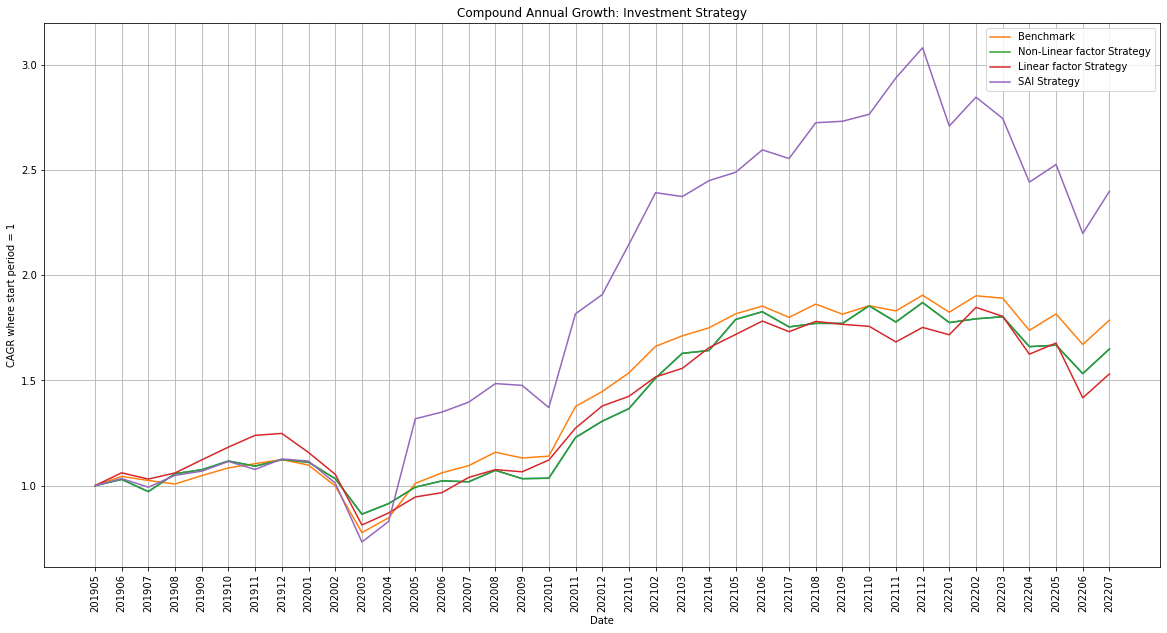

In [312]:
# Run the function to establish simple trades
df_sai_trades = trades_topquantile_generate(df_all_er=df_sai_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(start_period_trades(df_sai_trades)),int(start_period_trades(df_trades)),int(start_period_trades(df_nlf_trades)),int(start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_sec_cagr, p = run_sim(df_trades=df_sai_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = sim_chart(df_non_lin_sec_cagr)
sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy')
p.legend()
p.show()

<Figure size 432x288 with 0 Axes>

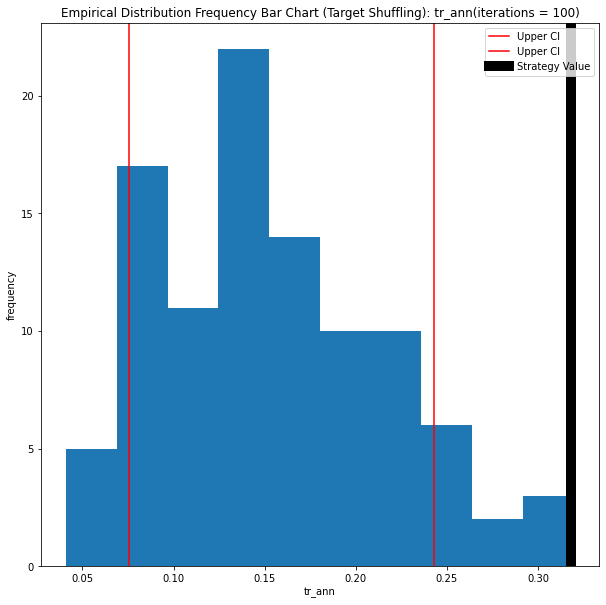

Empirical probability value of the strategy: tr_ann:0.99


<Figure size 432x288 with 0 Axes>

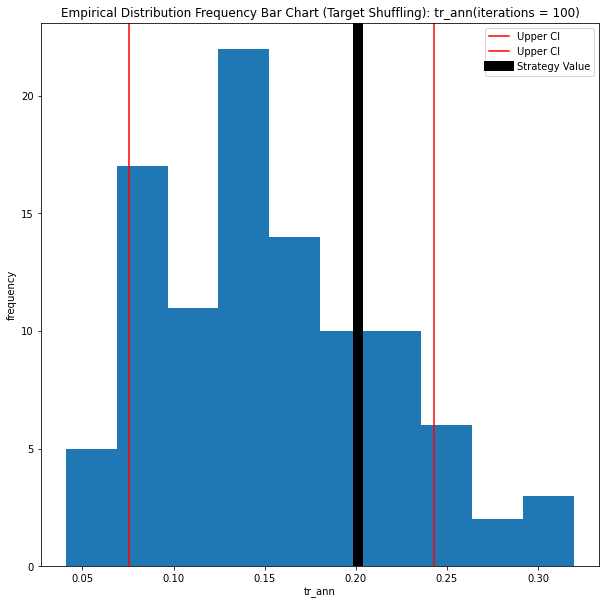

Empirical probability value of the strategy: tr_ann:0.76


In [313]:
# check the performance of the SAI simultation using target shuffling lite, to form an empirical distributon of returns
# Simulation
target_shuffling_chart(dt_target_shuffling_dist, df_sai_sec_cagr)
# benchmark
target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

# Stage4: Model Deployment

As we have alrteady seen with the Credit Use Case, model deployment requires 

Investment model deployment requires a rigorous change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of this stage is monitoring of data drift, and the monitoring of stakeholder KPIs which are principally for investors, and compliance needs.
For investors, the characteristics of the strategy that were marketed and agreed with the investor, should be monitored and reported regularly with sufficient executive oversight and repotring to support it.
For Compliance, regular checking that the investment elements of the strategy are fully compliant with the investment management agreement (IMA), which organisations will tend to have in place as a separate system in any case. 


# Stage 5: Model Monitoring and Reporting

##Stage5a: Data Drift

Our model is now in production and being used in practice. We need to monitor its stability. One approach is to monitor the distribution of the input data versus the data the model was trained with . If the distributions have shifted the model outcomes could be invalidated. Here we use our function data_drift_psi to monitor data drift.

Is it time for us to retrain our model?

In [315]:
# Get Data
#================================  
sai_train_X, sai_train_y = sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=0,  #<< Latest period
                                func_training_period=6,
                                buysell_threshold_quantile=0.75,
                                forecast_ahead=6, #<< Latest period
                                window_size=36) #<< Latest period

sai_test_X, sai_test_y = sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=0,  #<< Latest period
                                func_training_period=1,
                                buysell_threshold_quantile=0.75,
                                forecast_ahead=0, #<< Latest period
                                window_size=36) #<< Latest period


# Prepare train and test data for data drift check
train_datadrift = sai_train_X # pd.concat([sai_train_X, sai_train_y], axis=1)
test_datadrift = sai_test_X # pd.concat([sai_test_X, sai_test_y], axis=1)

# Data drift check...
data_drift_features = GovernanceUtils.data_drift_psi(train_datadrift, test_datadrift,buckettype='bins',buckets=10,axis=1,single_variable=False)
data_drift_target = data_drift_features[-1]

# Print out the target PSI value:
print("Target PSI value is ",data_drift_target, "\n" )

# Print out the features CSI values
print("The feature CSI values are:")
columns_features = train_datadrift.columns
index_value = 0
for x in columns_features:
  if data_drift_features[index_value] > 0.2:
          print(x, "*************** CSI value is over 0.2 = ",data_drift_features[index_value])
  elif data_drift_features[index_value] > 0.1:
          print(x, "*************** CSI value is over 0.1 = ",data_drift_features[index_value])
  else:
          print(x, "CSI is OK = ",data_drift_features[index_value])
  index_value = index_value + 1


The feature CSI values are:
const *************** CSI value is over 0.2 =  4.0536384673832115
mkt-rf *************** CSI value is over 0.2 =  1.466737352554395
smb *************** CSI value is over 0.2 =  3.8225894071965634
hml *************** CSI value is over 0.2 =  6.24601897985676
rmw *************** CSI value is over 0.2 =  7.877572961324212
cma *************** CSI value is over 0.2 =  7.877572961324212
Target PSI value is  7.877572961324212 

The feature CSI values are:
const *************** CSI value is over 0.2 =  4.0536384673832115
mkt-rf *************** CSI value is over 0.2 =  1.466737352554395
smb *************** CSI value is over 0.2 =  3.8225894071965634
hml *************** CSI value is over 0.2 =  6.24601897985676
rmw *************** CSI value is over 0.2 =  7.877572961324212
cma *************** CSI value is over 0.2 =  7.877572961324212


## Stage5b: Challenger Models

We have tested three types of stock selecion model in this notebook. We have selected the SAI approach, but we could still use the other models to provide another check on our live model, ie a **challenger model**.


# Afterword

We have done our best to include the key themes of what we think are the critical stages of model development in this notebook, but clearly in practice many more checks and details would be added to each of the 5 model development stages to best ensure stakeholder's KPIs are met, and Governance standards would be as high as possible. Hopefully our example and key themes will provide insight to avoid many of the classic biases in model development.